In [1]:
import numpy as np
import pandas as pd
import os
import gc

print(os.listdir("../input-hw3"))


['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [2]:
# credit to @guiferviz for the memory reduction 
def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

def reduce_memory_usage(df, deep=True, verbose=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")
    
    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
        

In [3]:
train_identity_data = pd.read_csv('../input-hw3/train_identity.csv')
train_transaction_data = pd.read_csv('../input-hw3/train_transaction.csv')

In [4]:
pd.set_option('display.max_columns', 500)
train_transaction_data.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
train_identity_data.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train_transaction_data['Transaction_dow'] = np.floor((train_transaction_data['TransactionDT'] / (3600 * 24) - 1) % 7)
train_transaction_data['Transaction_hour'] = np.floor(train_transaction_data['TransactionDT'] / 3600) % 24

In [7]:
na_columns = train_identity_data.isna().sum()
print(na_columns[na_columns==0])

TransactionID    0
id_01            0
id_12            0
dtype: int64


In [8]:
# number of nan values in each column
pd.set_option('display.max_rows', 500)
na_columns = train_transaction_data.isna().sum()
print(na_columns[na_columns==0])
print(na_columns[na_columns>0]/train_transaction_data.shape[0])

TransactionID       0
isFraud             0
TransactionDT       0
TransactionAmt      0
ProductCD           0
card1               0
C1                  0
C2                  0
C3                  0
C4                  0
C5                  0
C6                  0
C7                  0
C8                  0
C9                  0
C10                 0
C11                 0
C12                 0
C13                 0
C14                 0
Transaction_dow     0
Transaction_hour    0
dtype: int64
card2            0.015127
card3            0.002650
card4            0.002670
card5            0.007212
card6            0.002660
addr1            0.111264
addr2            0.111264
dist1            0.596524
dist2            0.936284
P_emaildomain    0.159949
R_emaildomain    0.767516
D1               0.002149
D2               0.475492
D3               0.445149
D4               0.286047
D5               0.524674
D6               0.876068
D7               0.934099
D8               0.873123
D9       

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(train_identity_data['id_01'])

In [10]:
transaction_data_columns = train_transaction_data.columns
numericCols = train_transaction_data._get_numeric_data().columns
categoricalCols = list(set(transaction_data_columns) - set(numericCols))
print('The categorical columns in transaction data are: ',categoricalCols)

The categorical columns in transaction data are:  ['card6', 'M7', 'M3', 'card4', 'M2', 'ProductCD', 'R_emaildomain', 'M5', 'M1', 'P_emaildomain', 'M4', 'M9', 'M6', 'M8']


In [11]:
train_transaction_data[categoricalCols] = train_transaction_data[categoricalCols].replace({ np.nan:'missing'})
train_transaction_data[numericCols] = train_transaction_data[numericCols].replace({ np.nan:-1})

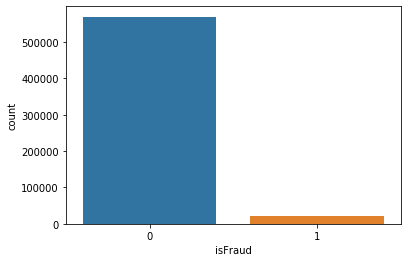

In [12]:
sns.countplot(train_transaction_data['isFraud'])

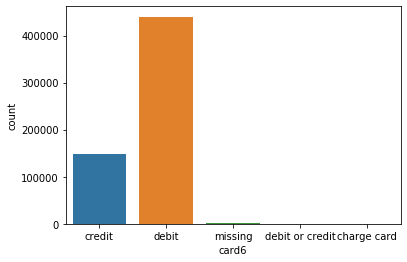

In [13]:
sns.countplot(train_transaction_data['card6'])

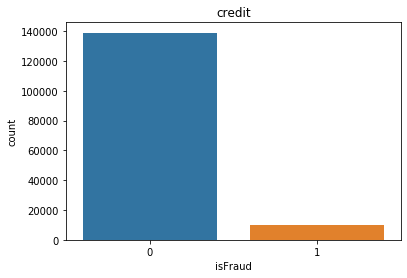

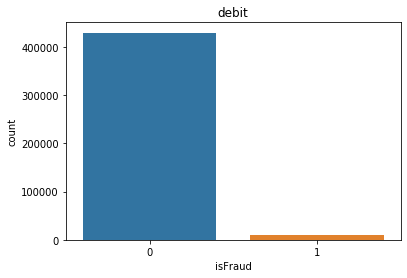

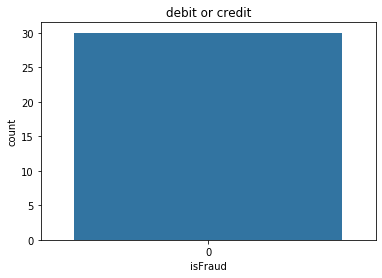

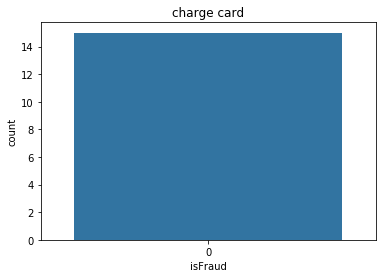

In [14]:
cardTypes = ['credit','debit','debit or credit','charge card']
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card6"]=="'+i_card+'"]')
    plt.figure(i)
    sns.countplot(cardData['isFraud']).set_title(i_card)

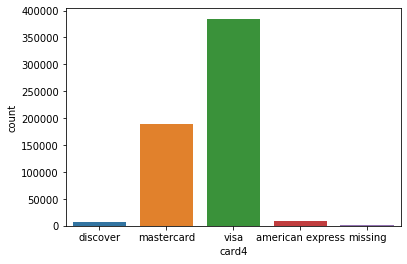

In [15]:
sns.countplot(train_transaction_data['card4'])

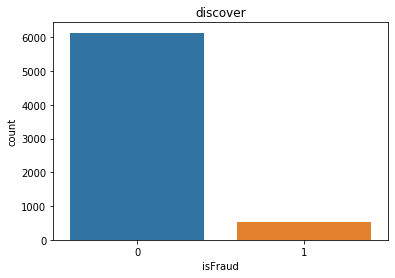

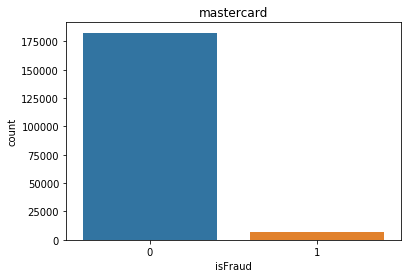

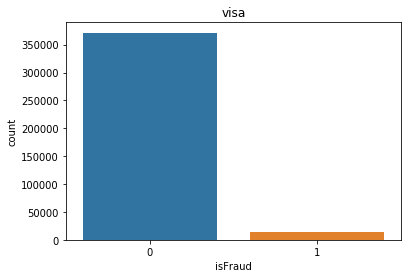

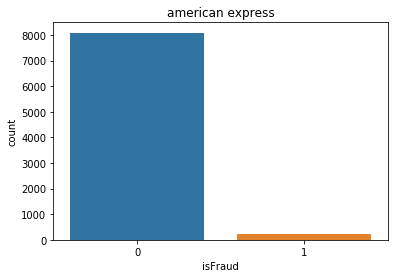

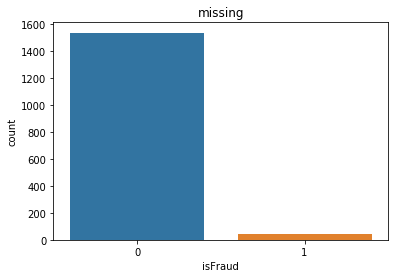

In [16]:
cardTypes = ['discover','mastercard','visa','american express','missing']
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card4"]=="'+i_card+'"]')
    plt.figure(i)
    sns.countplot(cardData['isFraud']).set_title(i_card)

In [17]:
print('The average transaction amount for non fraudulent transactions is: ', 
      np.mean(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The average transaction amount for fraudulent transactions is: ', 
      np.mean(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The average transaction amount for non fraudulent transactions is:  134.51166457849672
The average transaction amount for fraudulent transactions is:  149.24477858974976


In [18]:
print('The Maximum transaction amount for non fraudulent transactions is: ', 
      np.max(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The Maximum transaction amount for fraudulent transactions is: ', 
      np.max(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The Maximum transaction amount for non fraudulent transactions is:  31937.391
The Maximum transaction amount for fraudulent transactions is:  5191.0


In [19]:
print('The Minimum transaction amount for non fraudulent transactions is: ', 
      np.min(train_transaction_data.loc[train_transaction_data["isFraud"]==0]['TransactionAmt']))
print('The Minimum transaction amount for fraudulent transactions is: ', 
      np.min(train_transaction_data.loc[train_transaction_data["isFraud"]==1]['TransactionAmt']))

The Minimum transaction amount for non fraudulent transactions is:  0.251
The Minimum transaction amount for fraudulent transactions is:  0.292


In [20]:
maxCardData = {}
minCardData = {}
meanCardData = {}
for i,i_card in enumerate(cardTypes):
    cardData = eval('train_transaction_data.loc[train_transaction_data["card4"]=="'+i_card+'"]')
    maxCardData[i_card] = np.max(cardData['TransactionAmt'])
    minCardData[i_card] = np.min(cardData['TransactionAmt'])
    meanCardData[i_card] = np.mean(cardData['TransactionAmt'])

In [21]:
print('The maximum transactions by card are:', maxCardData)
print('The minimum transactions by card are:', minCardData)
print('The average transactions by card are:', meanCardData)

The maximum transactions by card are: {'discover': 4817.58, 'mastercard': 31937.391, 'visa': 6450.97, 'american express': 1800.0, 'missing': 4545.36}
The minimum transactions by card are: {'discover': 5.0, 'mastercard': 0.272, 'visa': 0.251, 'american express': 5.0, 'missing': 2.6}
The average transactions by card are: {'discover': 265.7504254999248, 'mastercard': 132.38773137191689, 'visa': 133.16180560702972, 'american express': 173.05713664745437, 'missing': 154.68928091312617}


In [22]:
normalDataTransaction = train_transaction_data.loc[train_transaction_data["isFraud"]==0]
normalDataTransaction.TransactionAmt.describe()

count    569877.000000
mean        134.511665
std         239.395078
min           0.251000
25%          43.970000
50%          68.500000
75%         120.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

In [23]:
fraudDataTransaction = train_transaction_data.loc[train_transaction_data["isFraud"]==1]
fraudDataTransaction.TransactionAmt.describe()

count    20663.000000
mean       149.244779
std        232.212163
min          0.292000
25%         35.044000
50%         75.000000
75%        161.000000
max       5191.000000
Name: TransactionAmt, dtype: float64

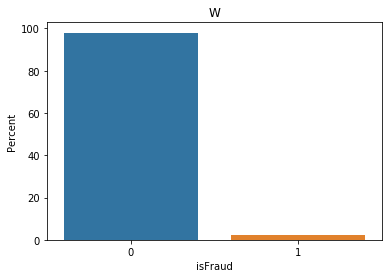

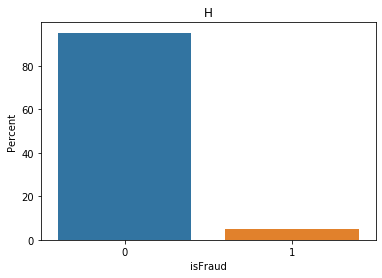

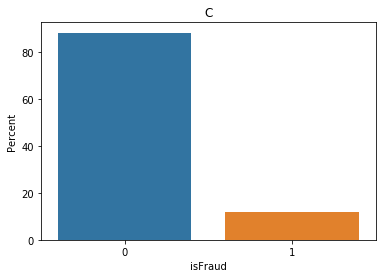

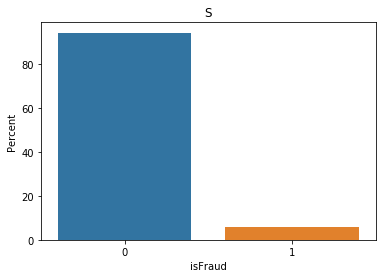

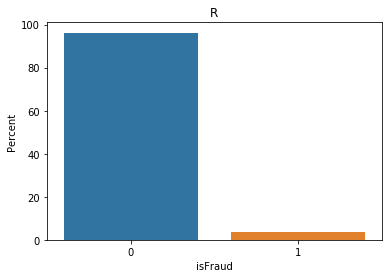

In [24]:
prodTypes = train_transaction_data['ProductCD'].unique()
for i,i_prod in enumerate(prodTypes):
    productData = eval('train_transaction_data.loc[train_transaction_data["ProductCD"]=="'+i_prod+'"]')
    plt.figure(i)
    ax = sns.barplot(x="isFraud", y="isFraud", data=productData, estimator=lambda x: len(x) / len(productData) * 100)
    ax.set(ylabel="Percent")
    ax.set_title(i_prod)

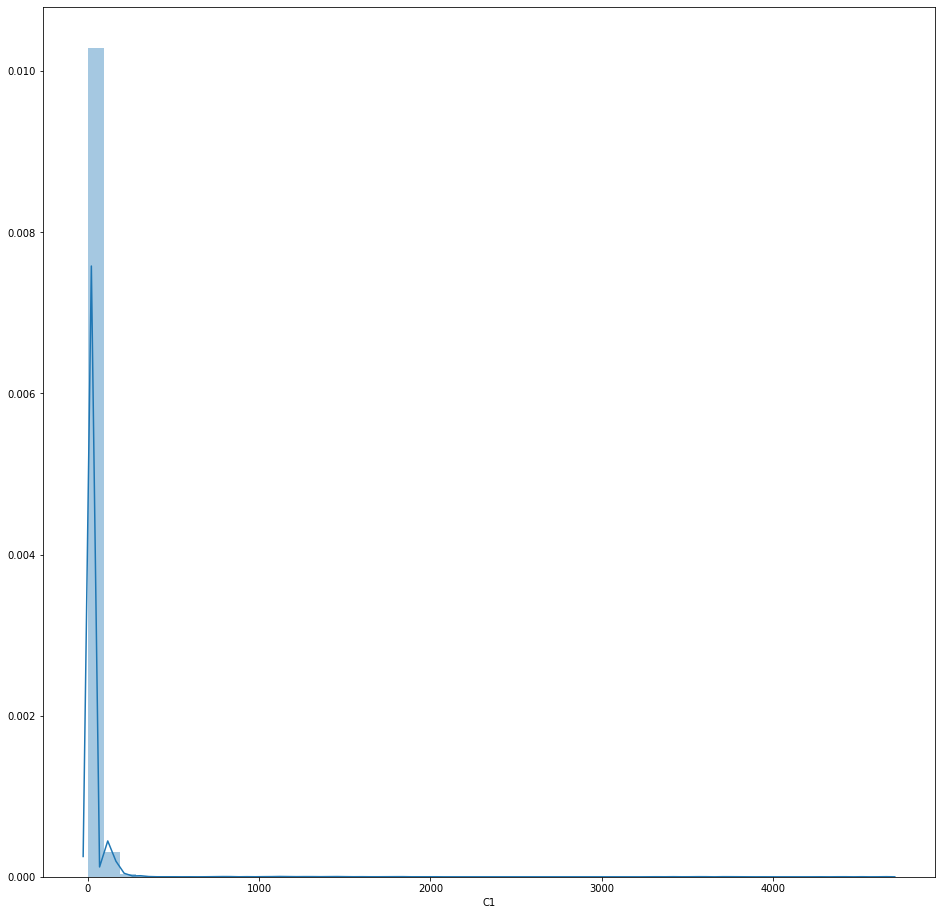

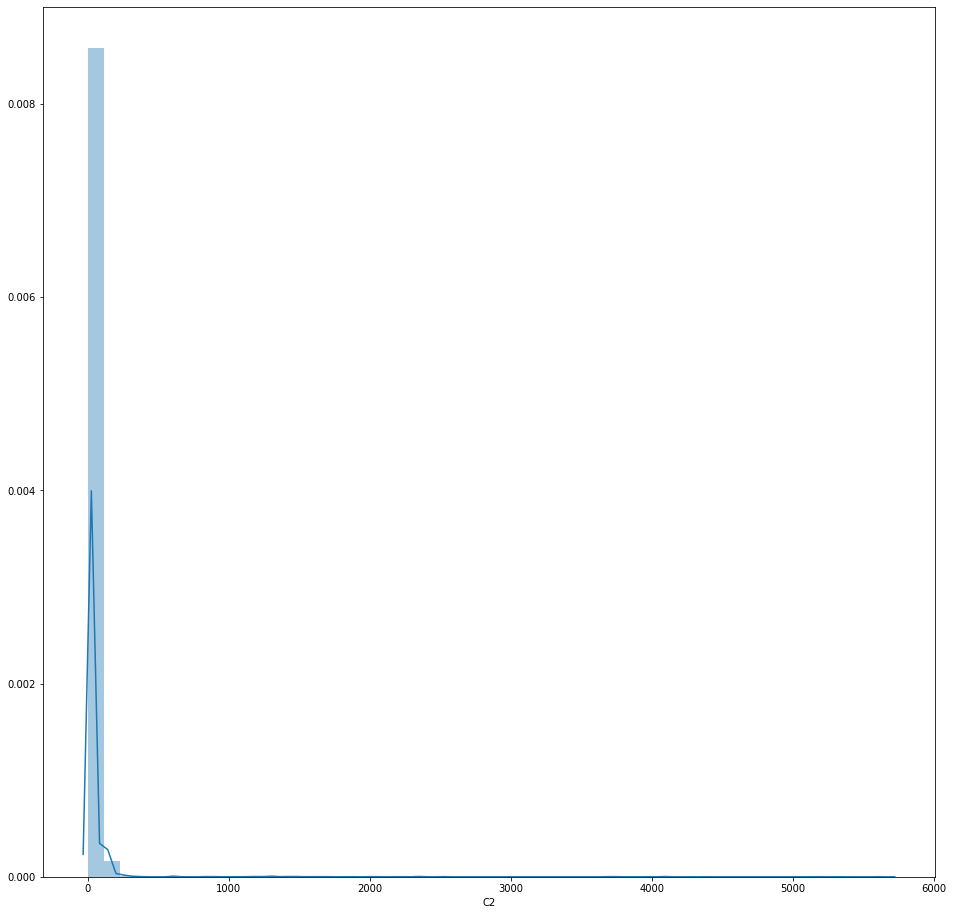

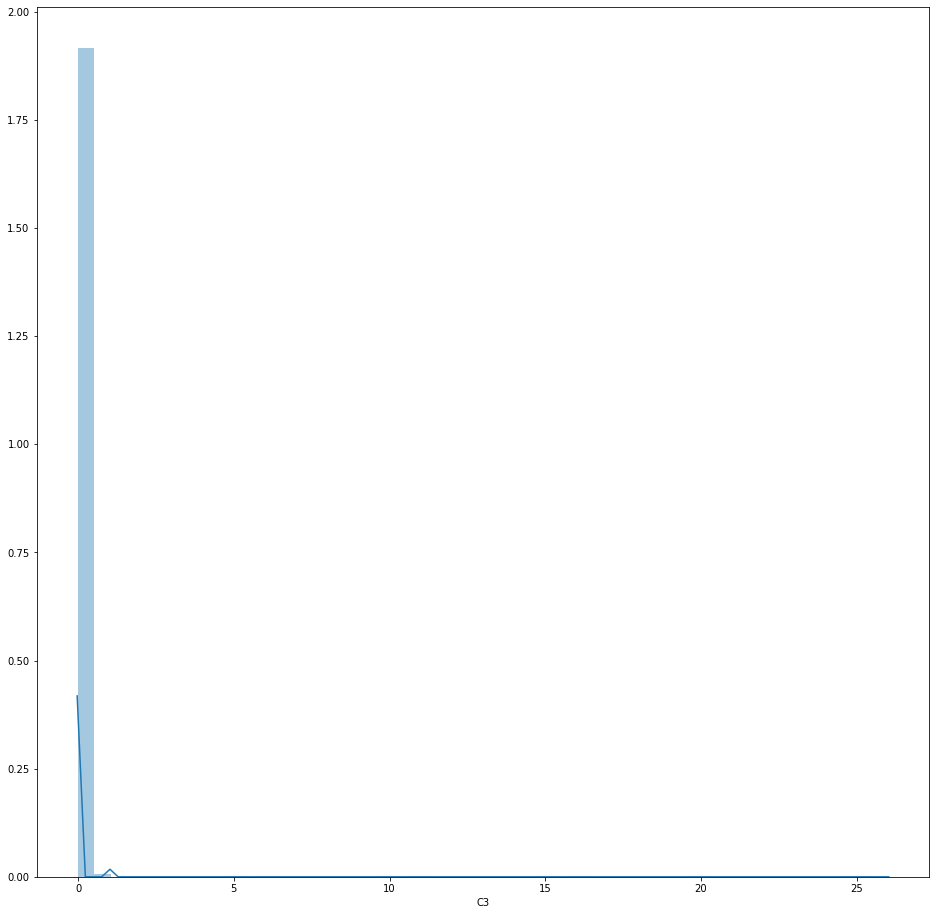

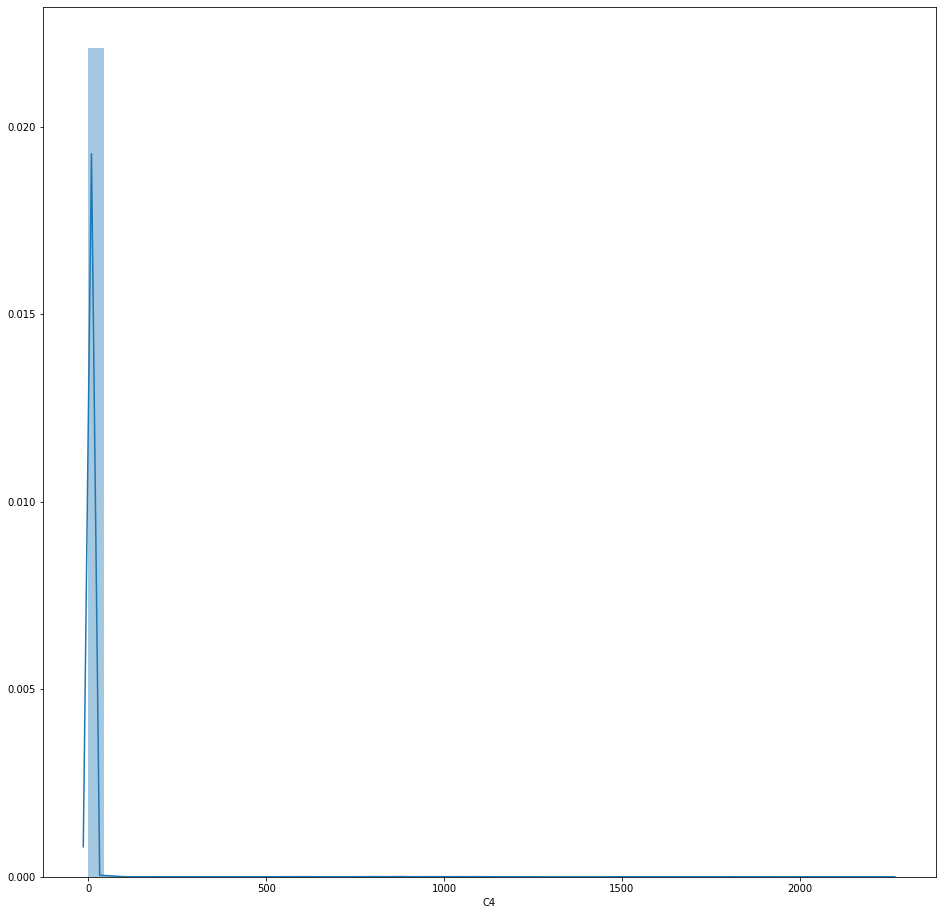

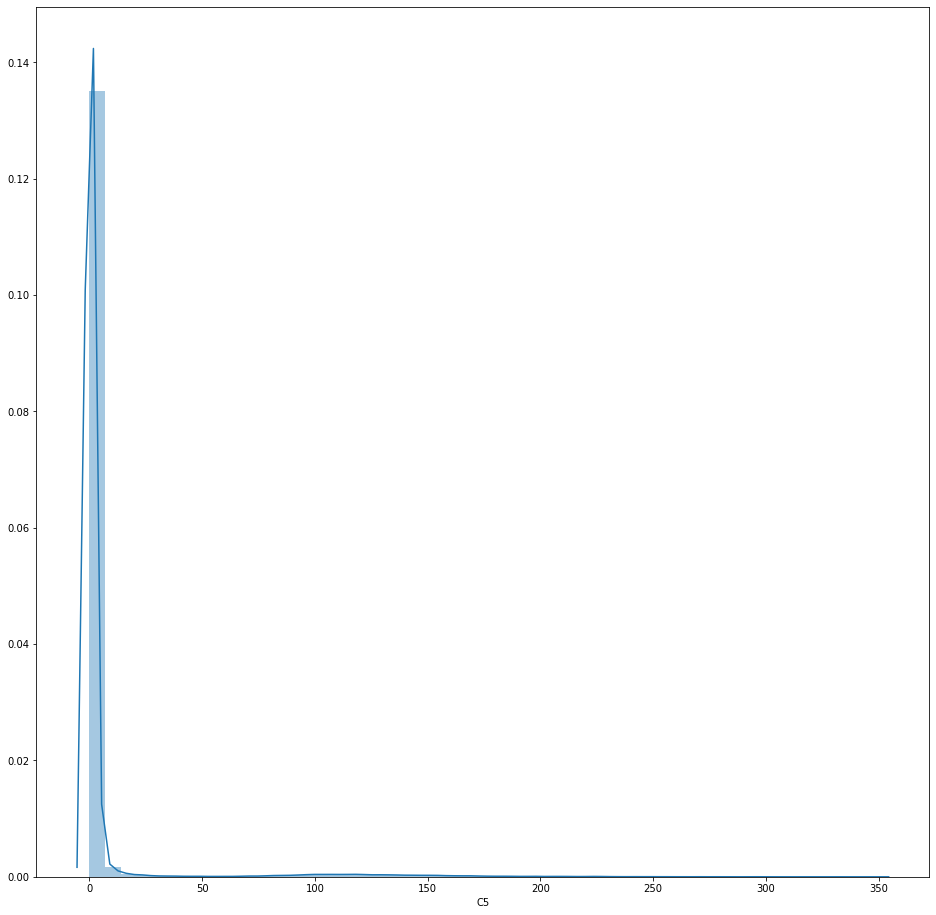

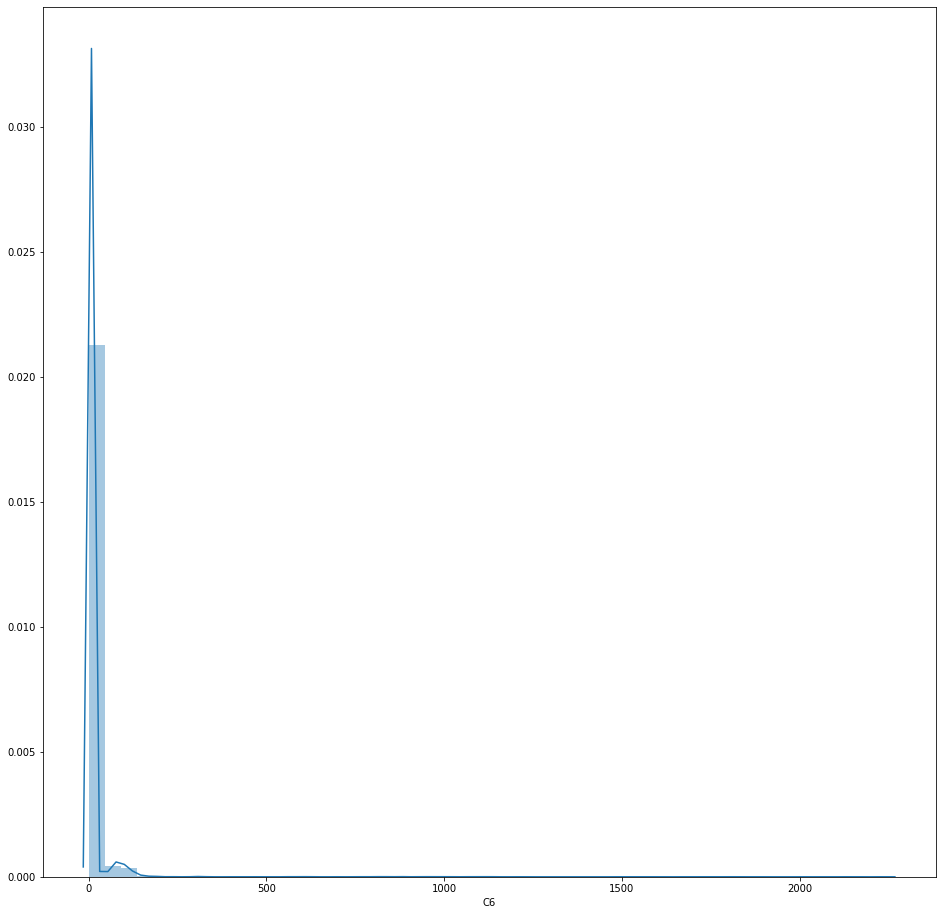

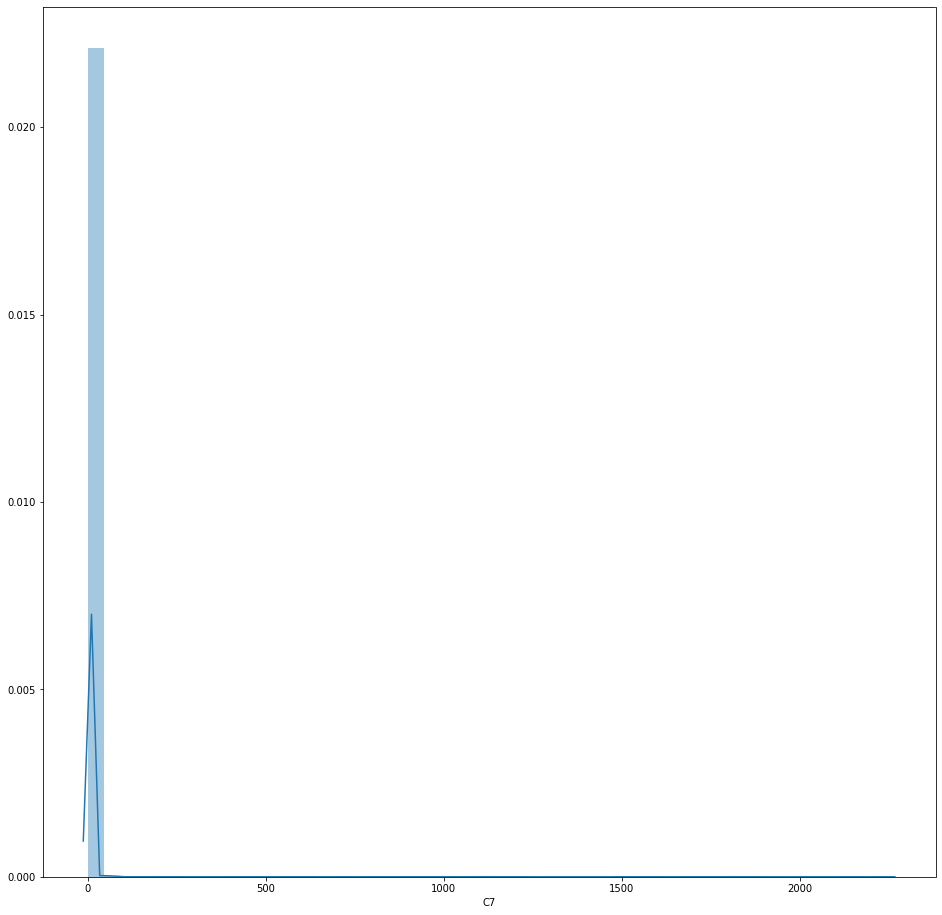

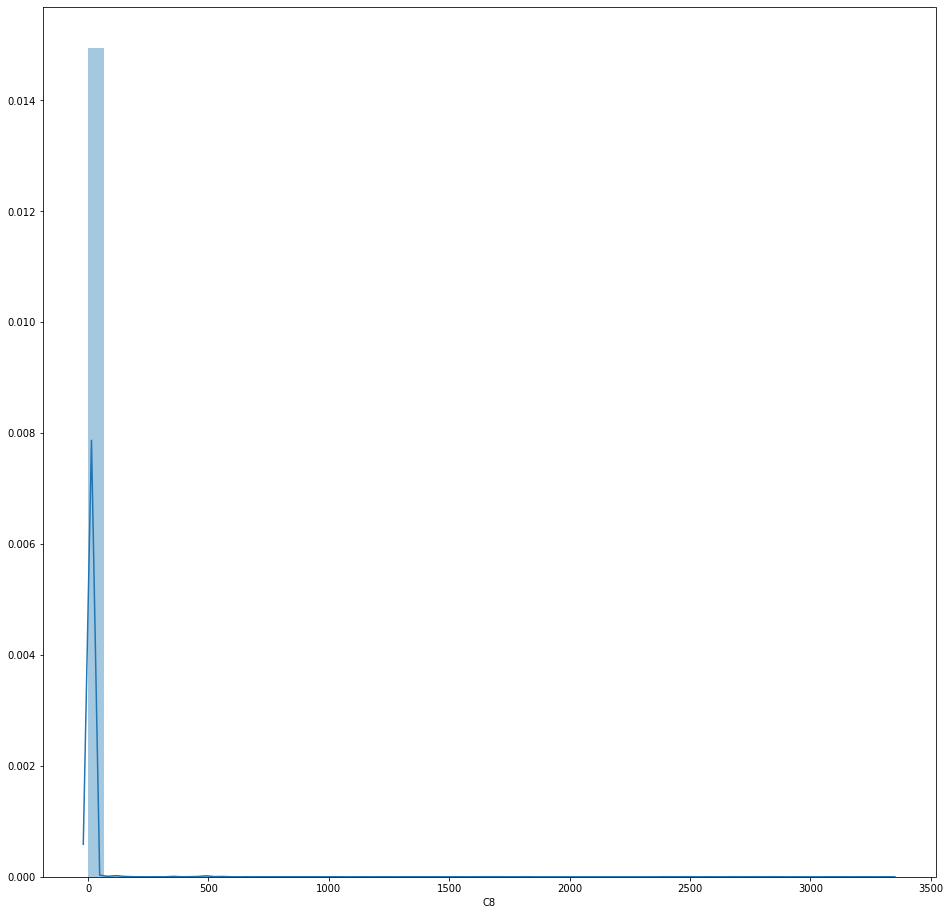

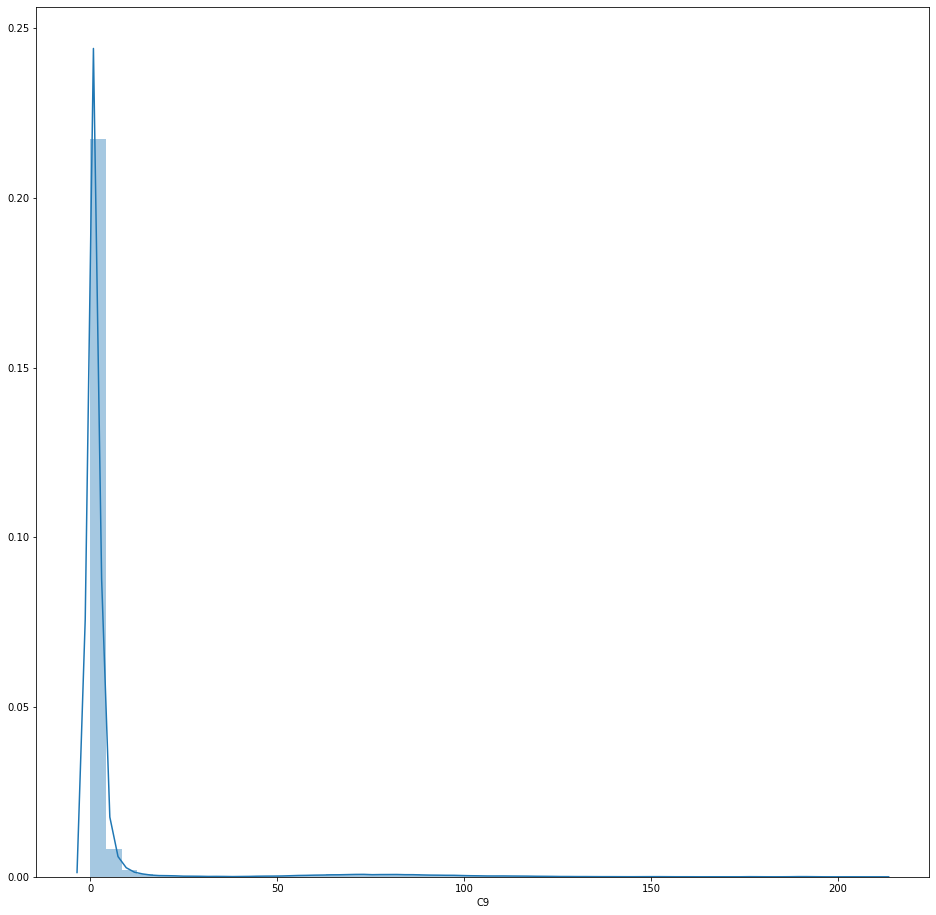

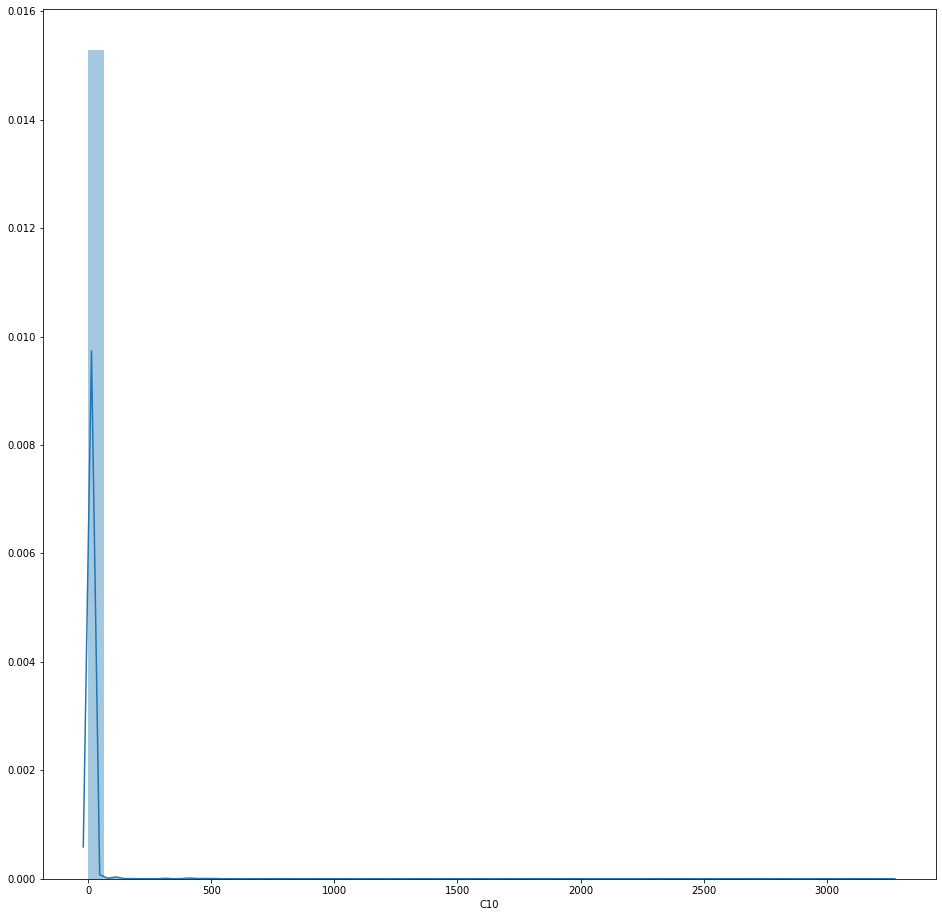

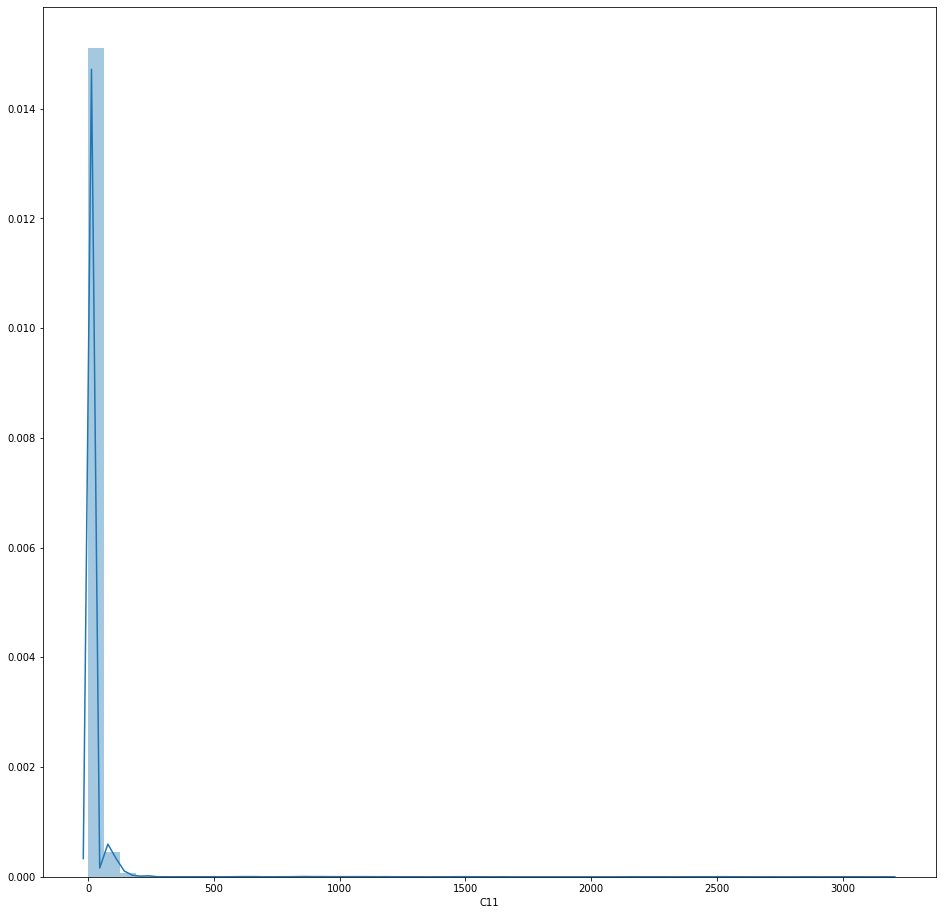

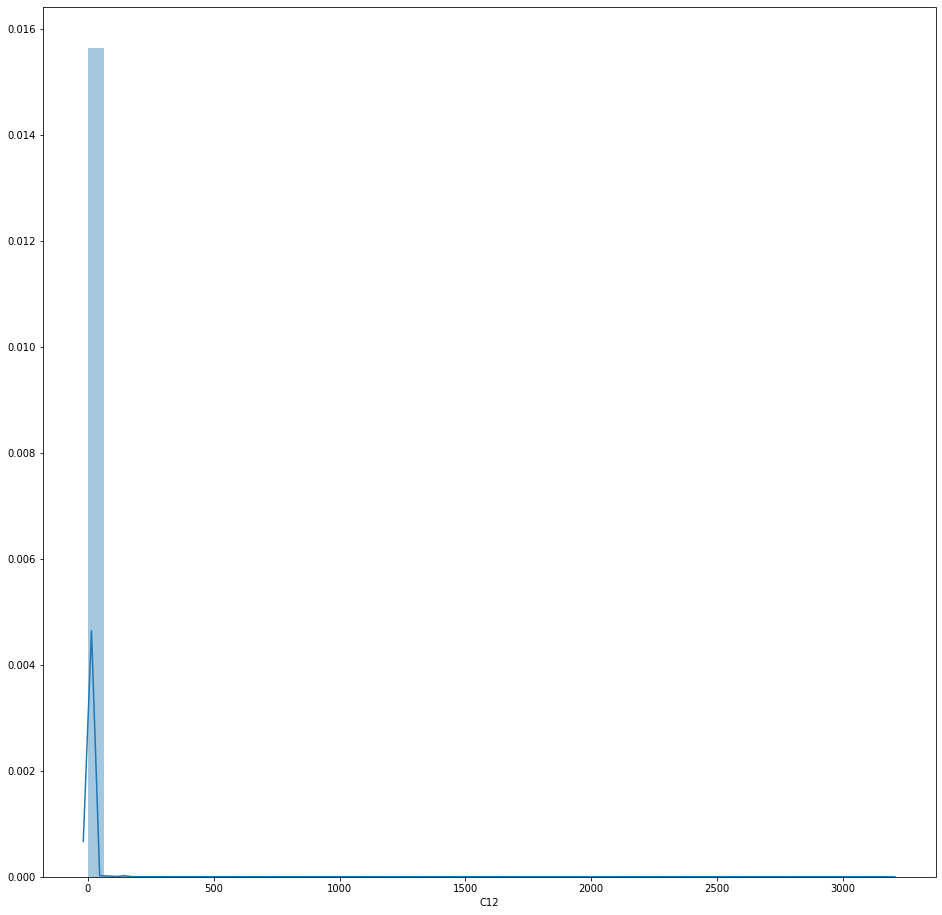

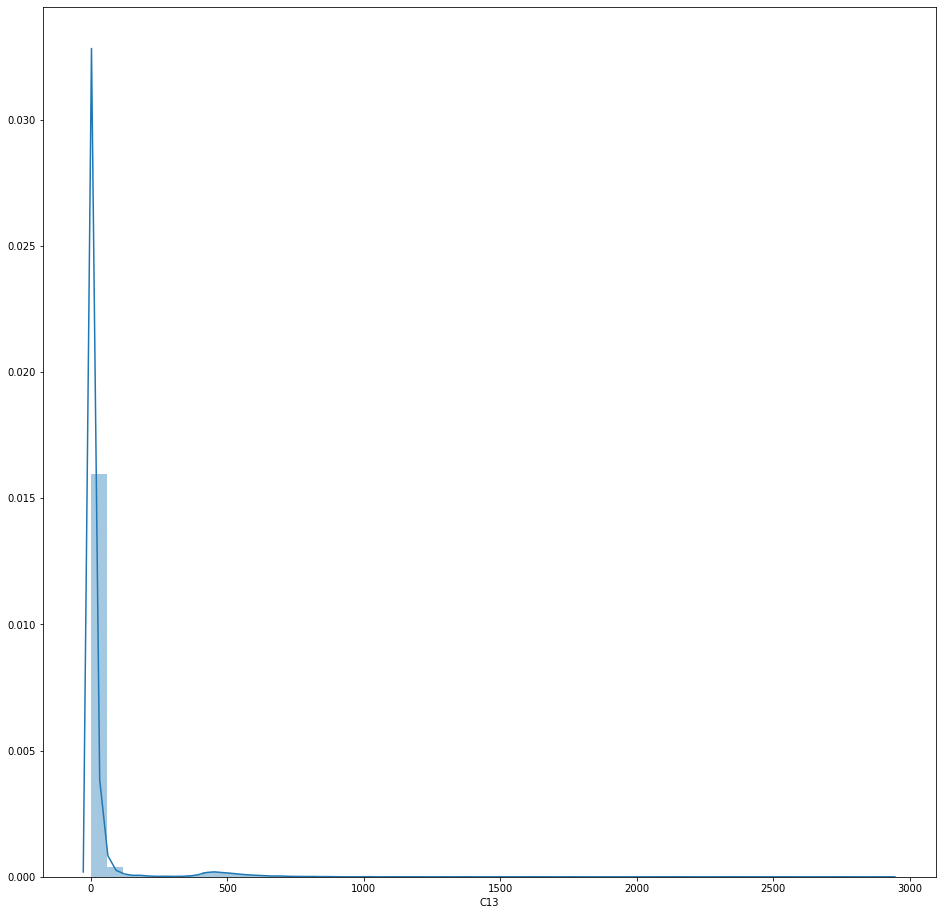

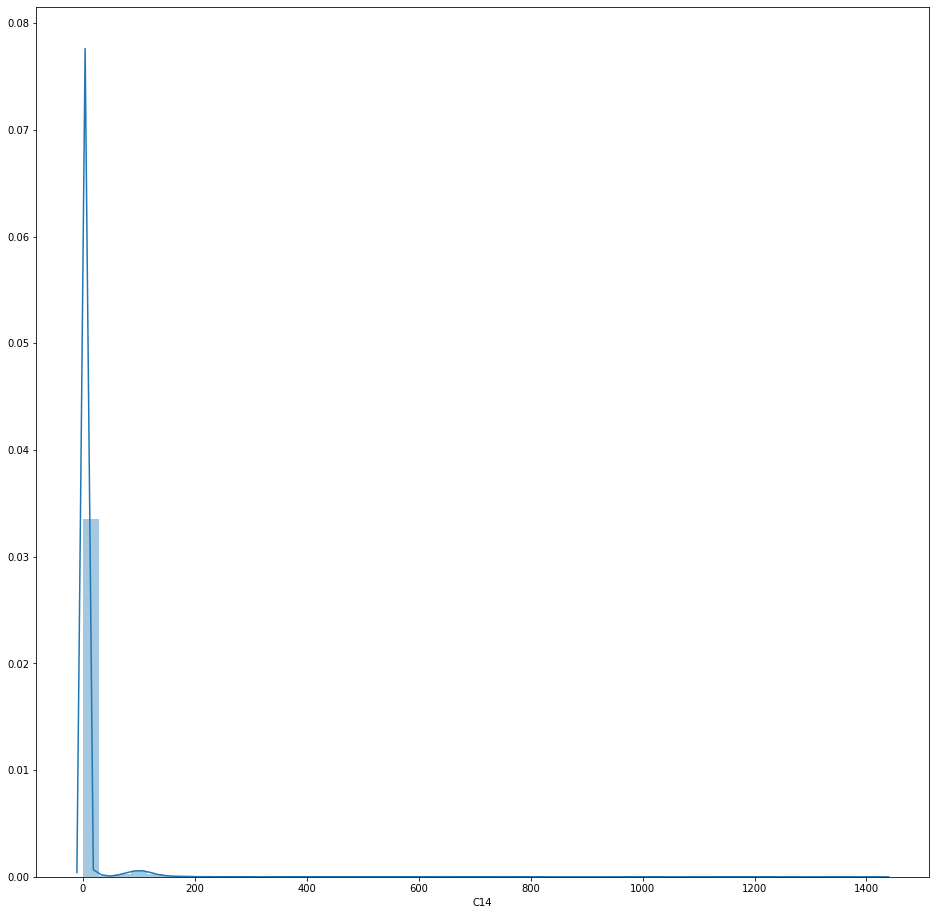

In [25]:
for i in range(1,15):    
    plt.figure(figsize=(16, 16))
    sns.distplot(eval('train_transaction_data["C'+str(i)+'"]'))
    ax.set(ylabel="Distribution")
    ax.set_title(['C'+str(i)])    

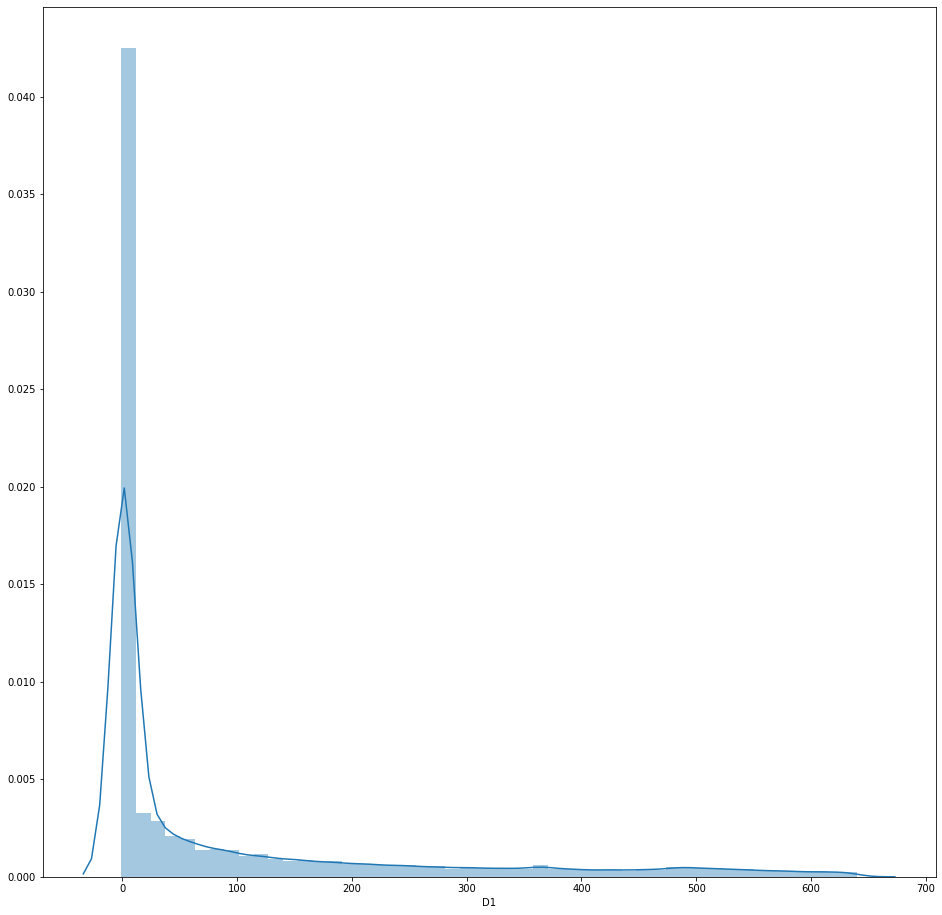

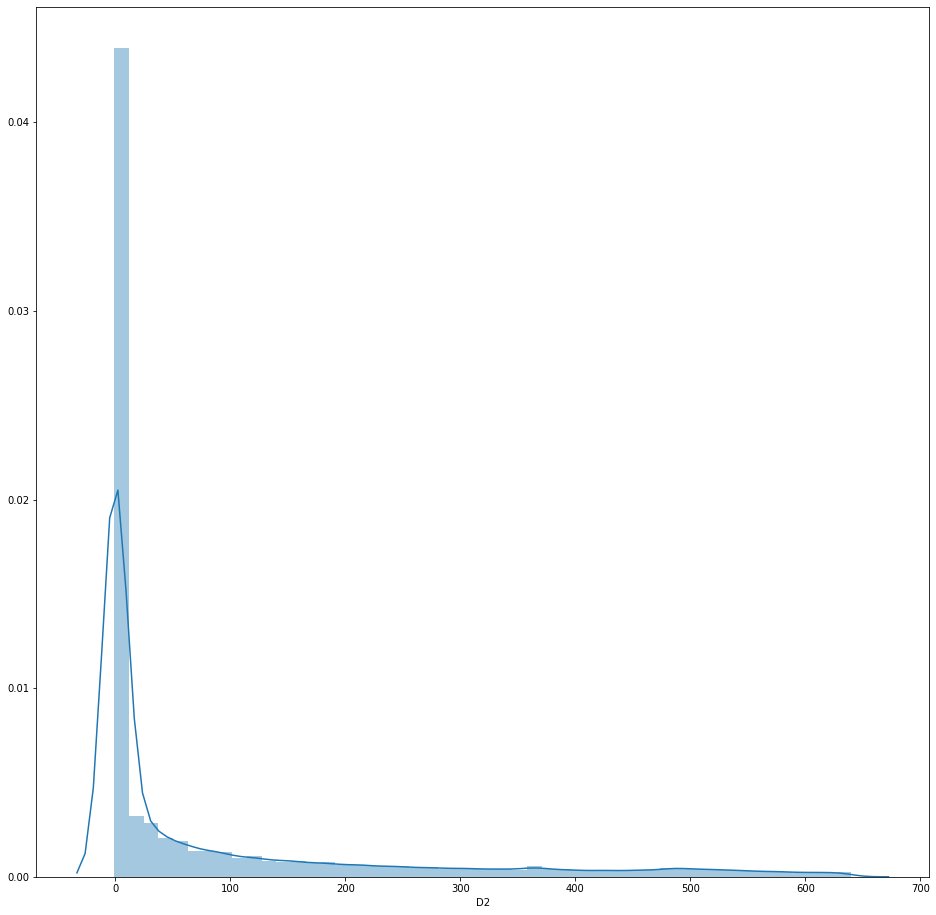

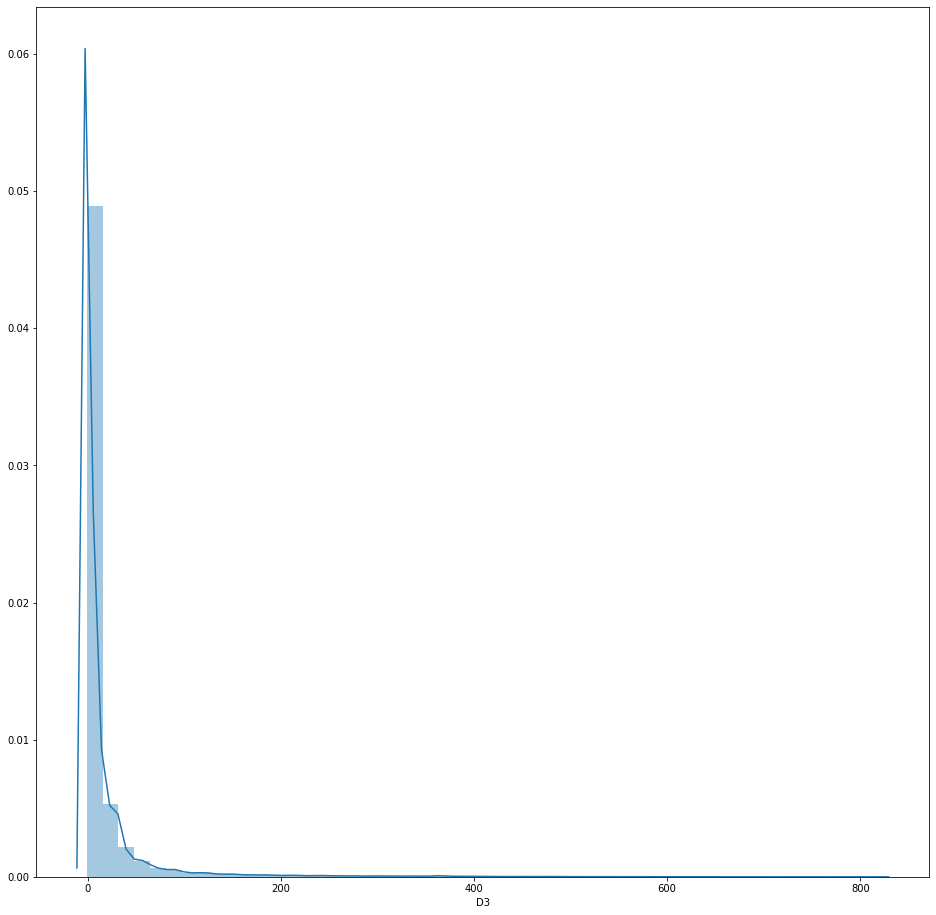

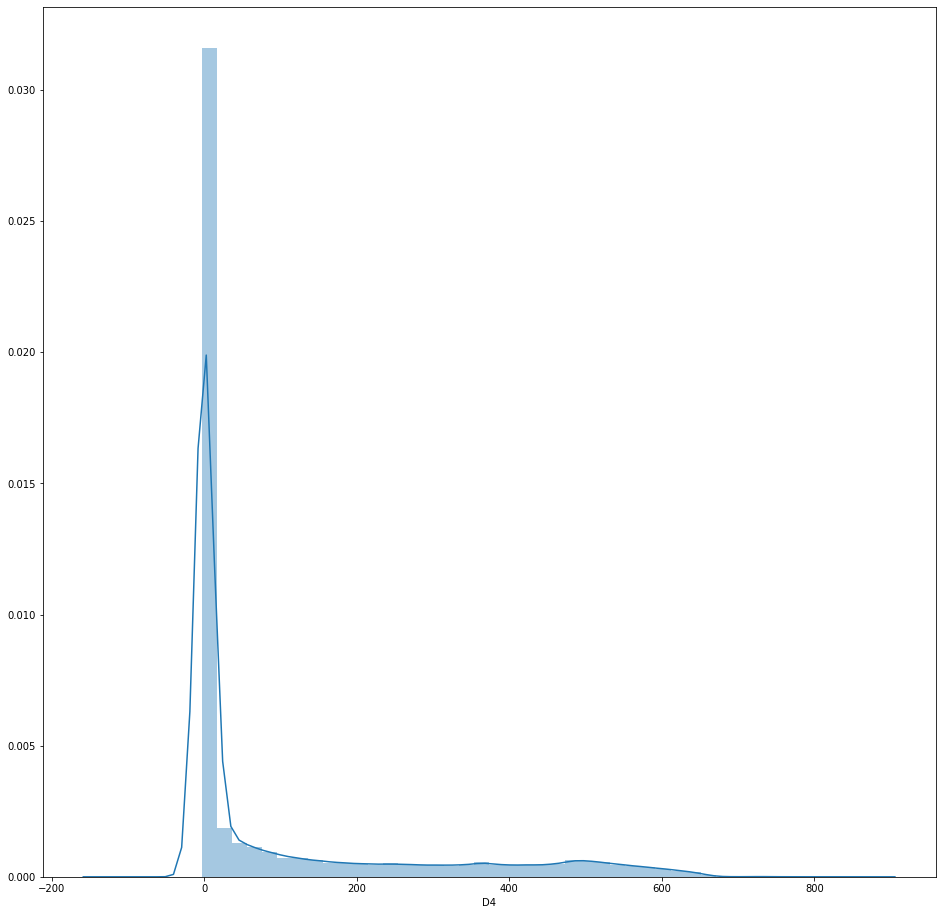

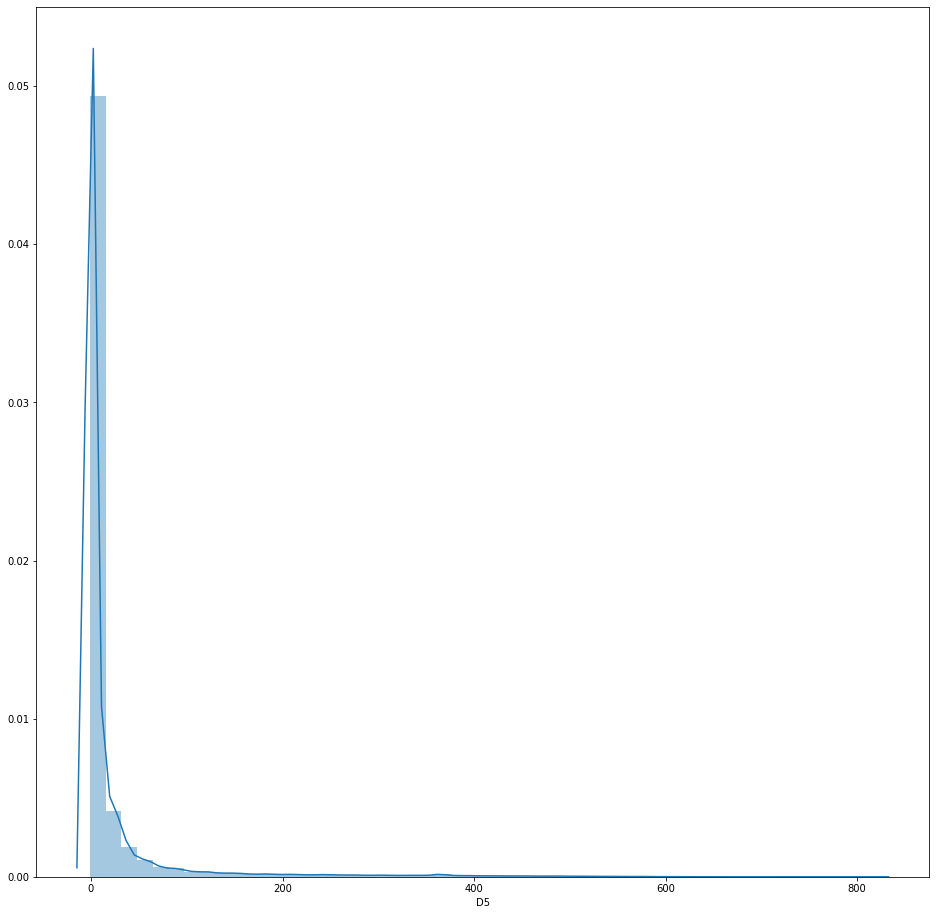

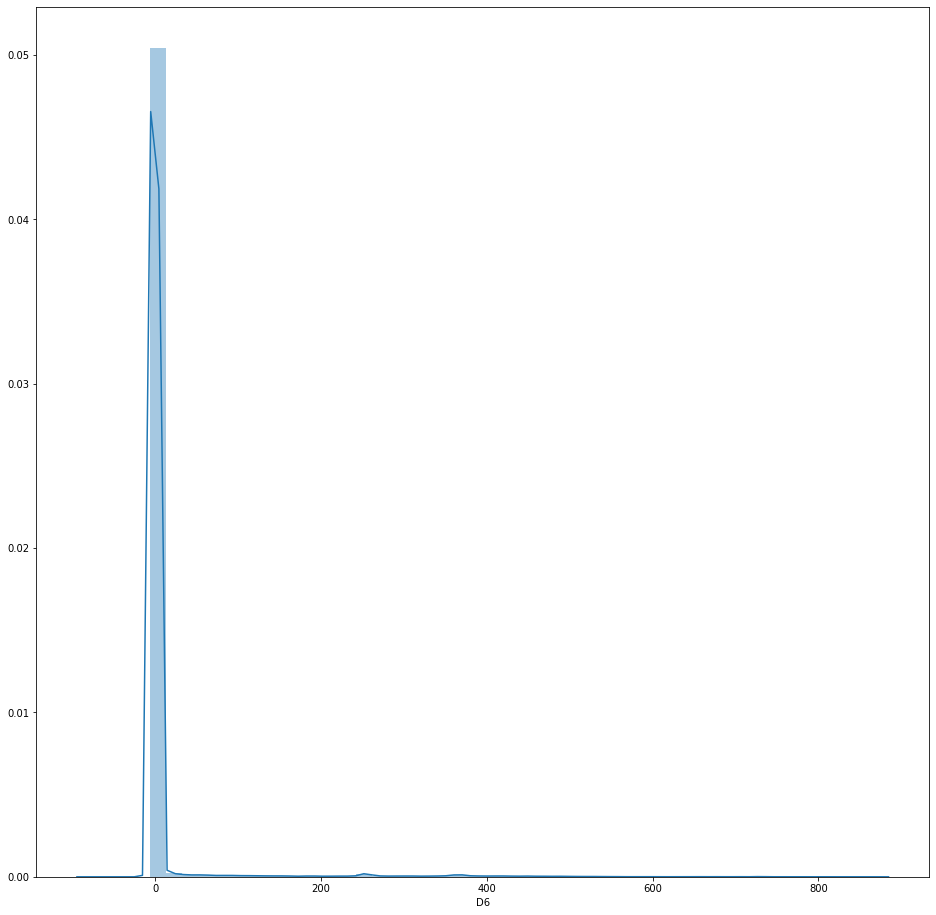

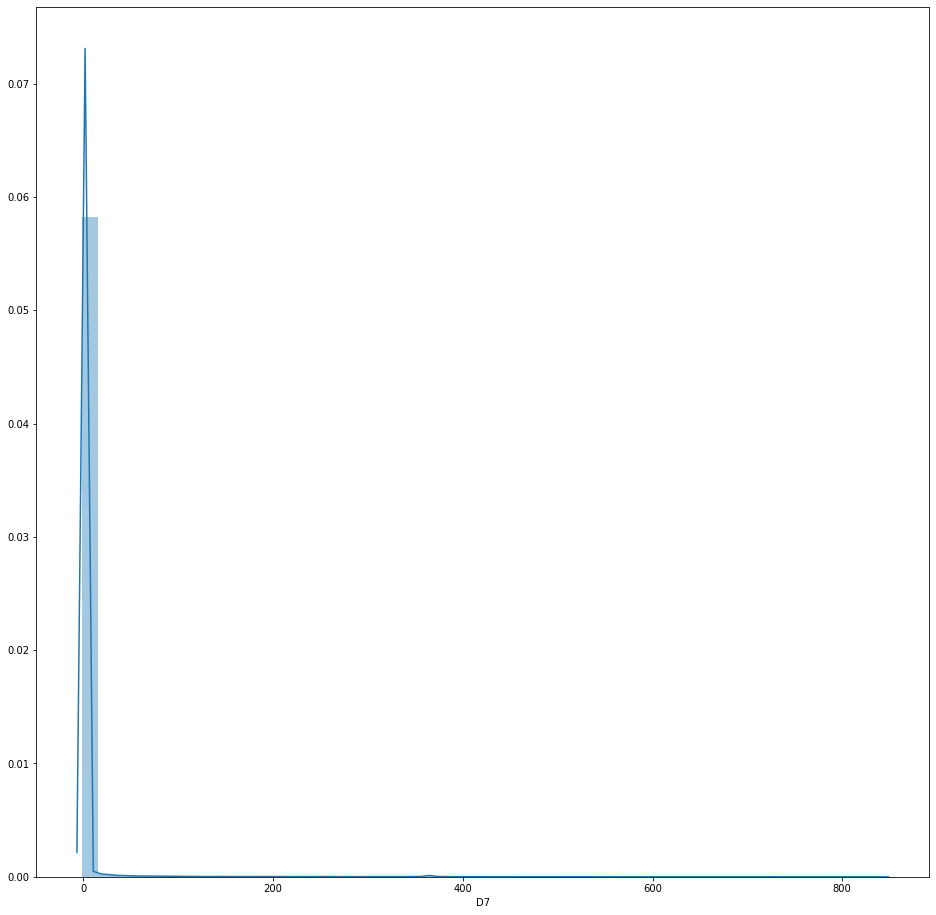

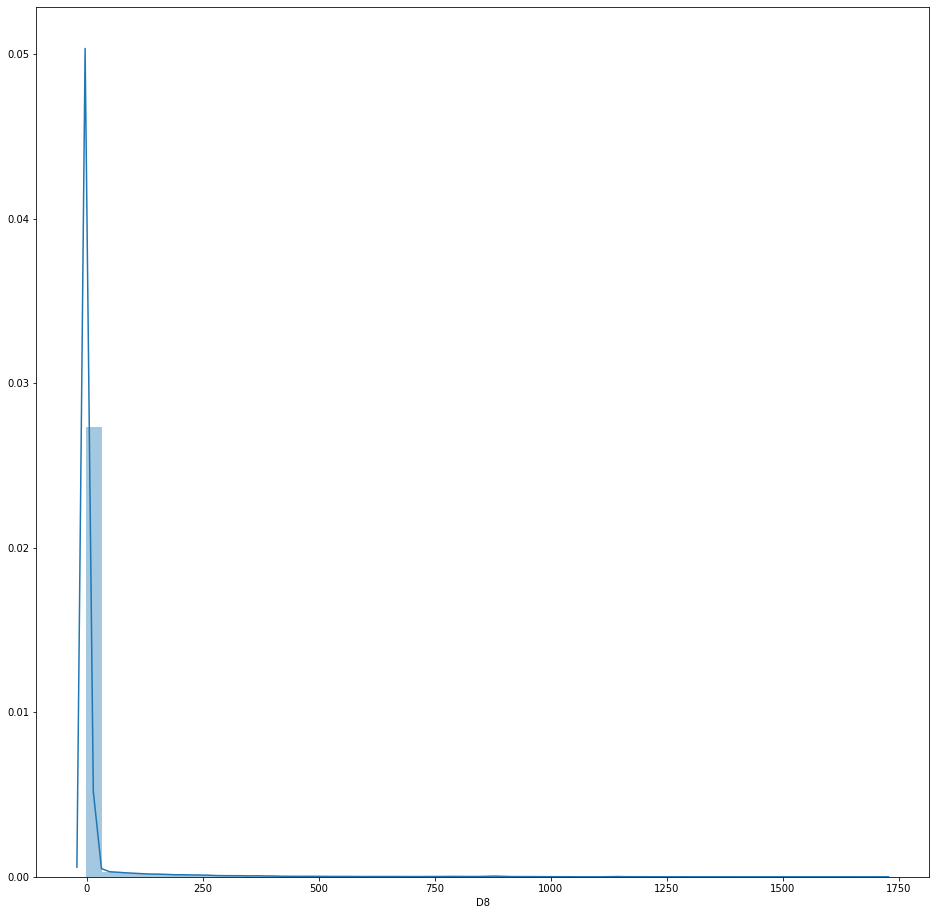

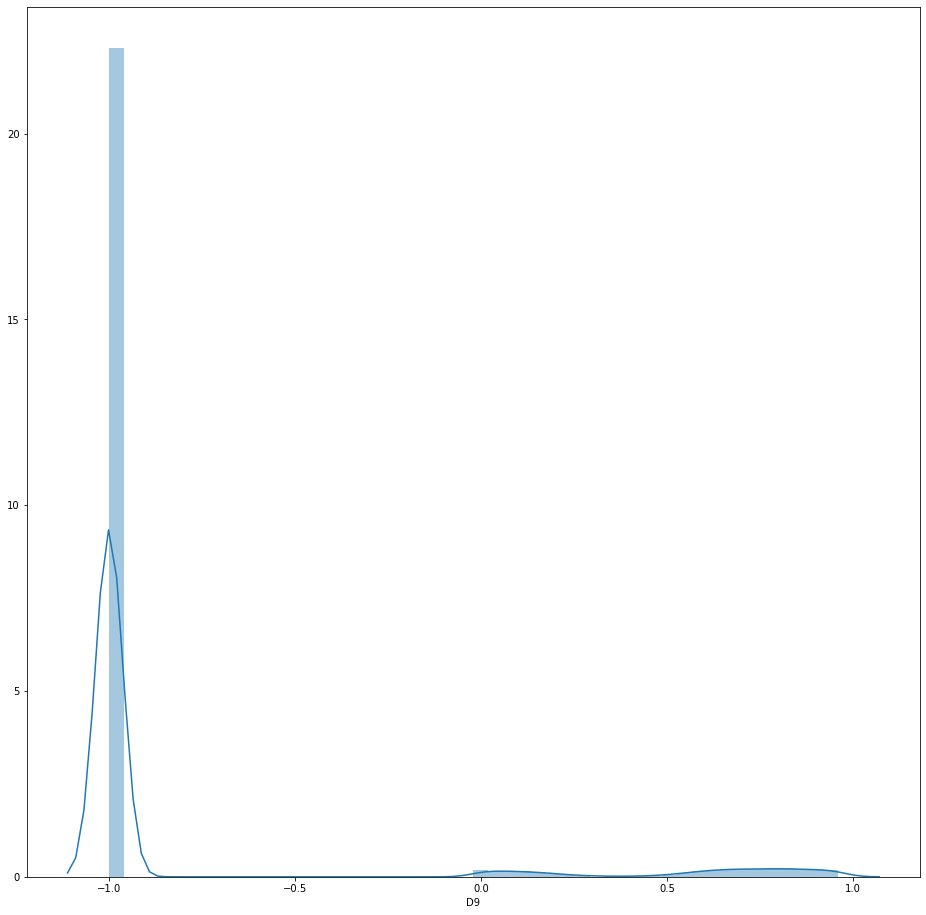

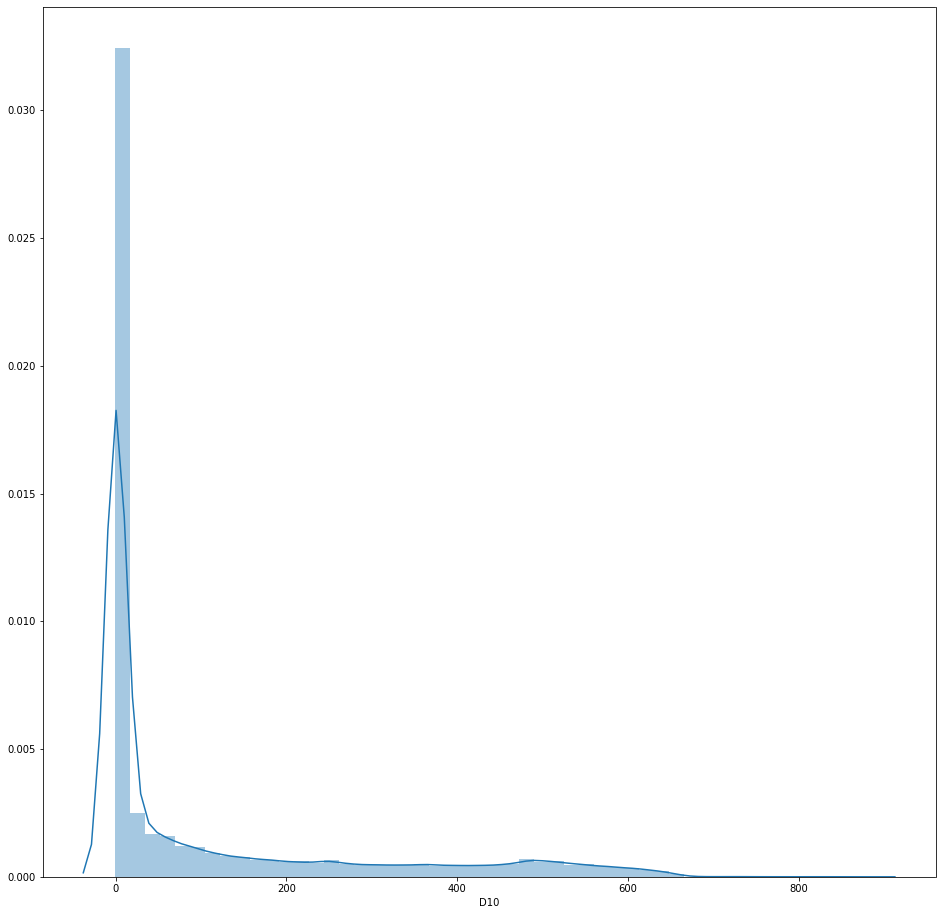

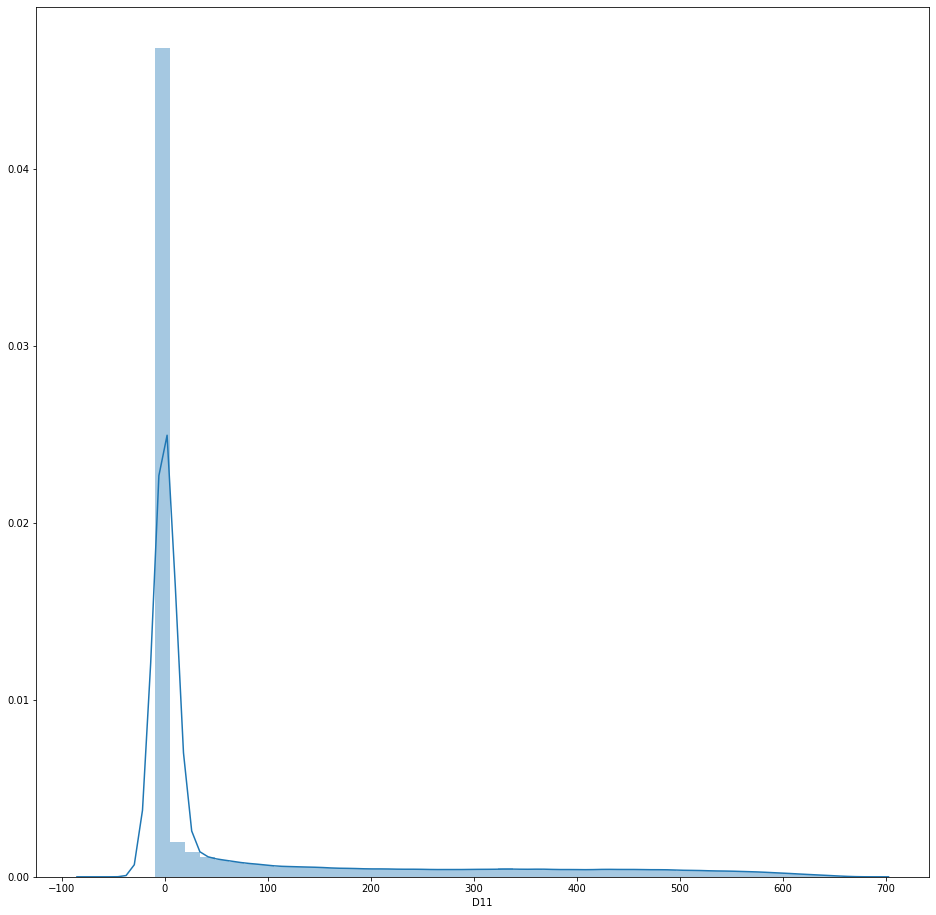

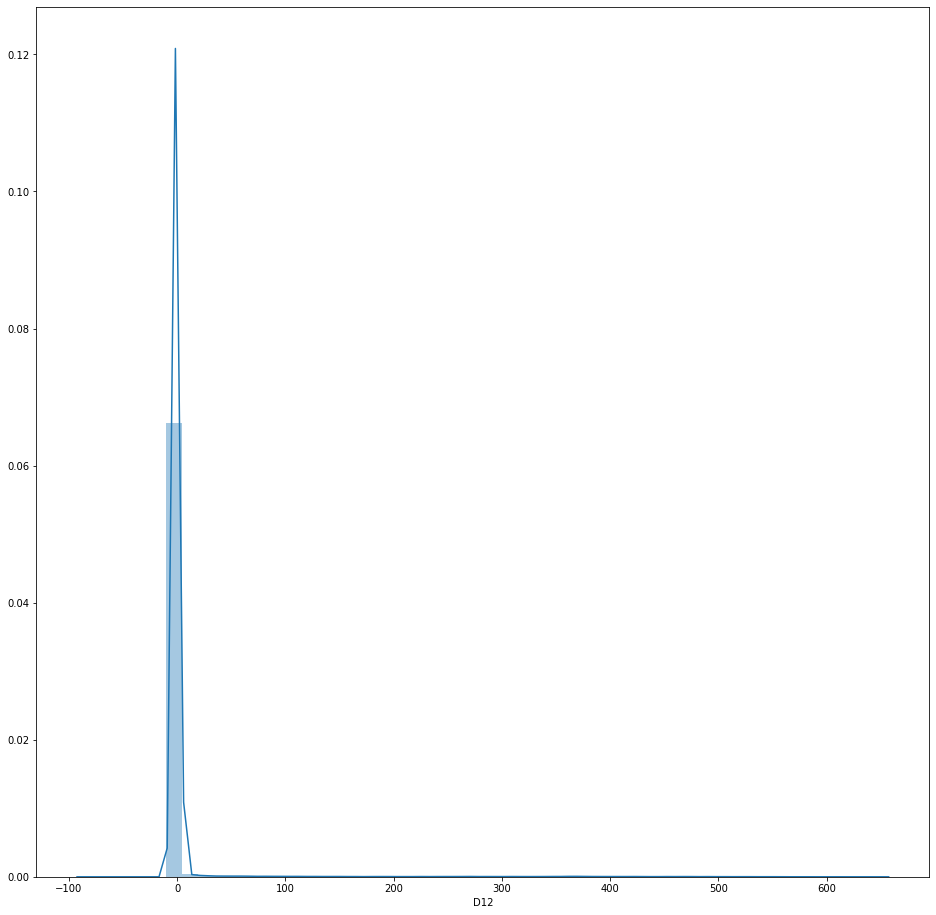

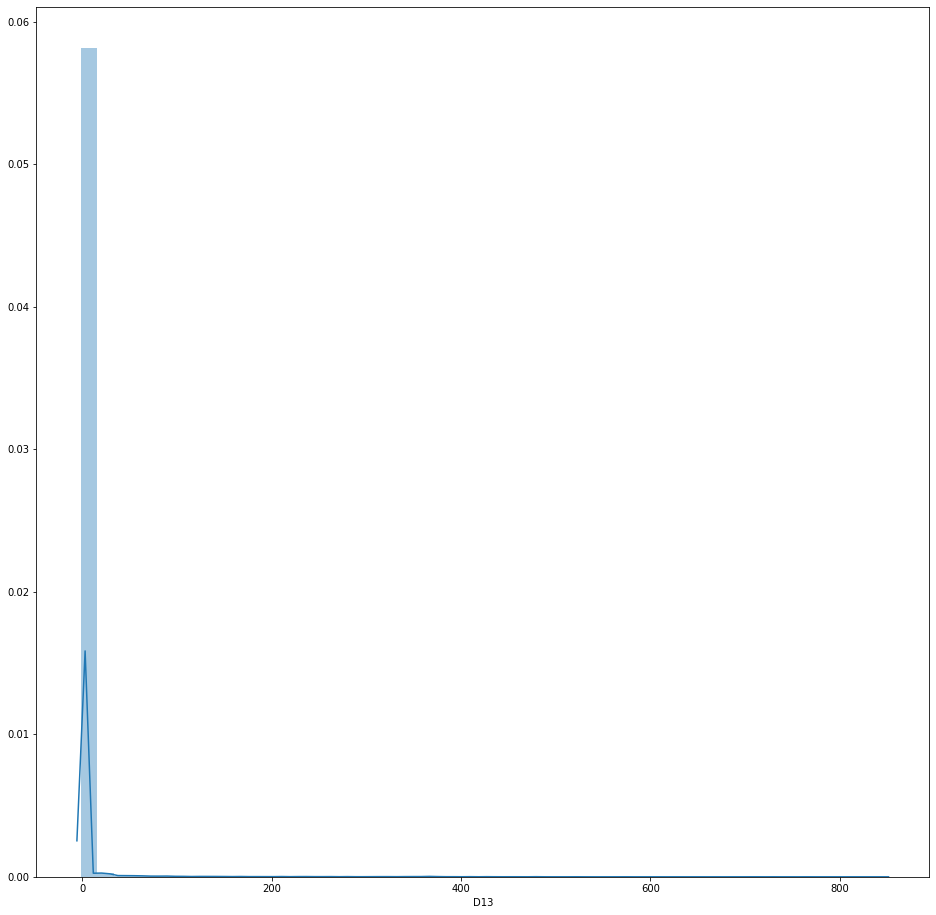

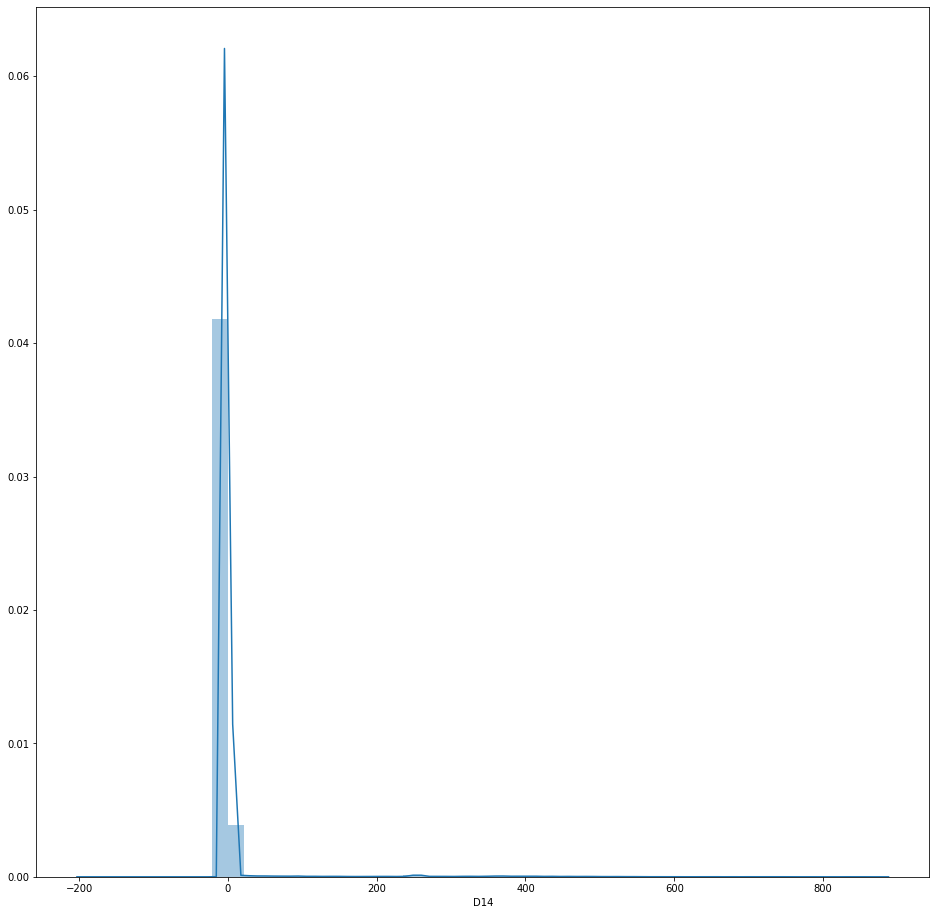

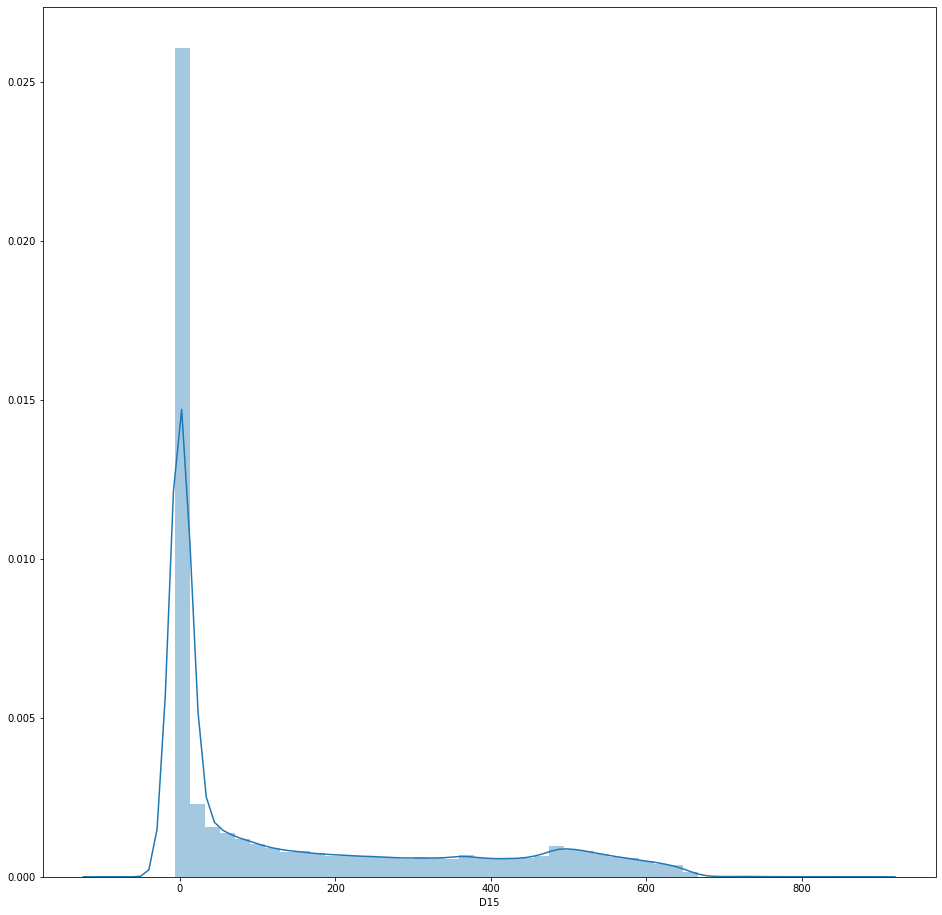

In [26]:
for i in range(1,16):    
    plt.figure(figsize=(16, 16))
    sns.distplot(eval('train_transaction_data["D'+str(i)+'"]'))
    ax.set(ylabel="Distribution")
    ax.set_title(['D'+str(i)])   

In [27]:
del fraudDataTransaction,normalDataTransaction,productData,cardData

In [28]:
print(train_identity_data.columns)

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')


In [29]:
identity_data_columns = train_identity_data.columns
numericCols = train_identity_data._get_numeric_data().columns
categoricalCols = list(set(identity_data_columns) - set(numericCols))
print('The categorical columns in identity data are: ',categoricalCols)
train_identity_data[categoricalCols] = train_identity_data[categoricalCols].replace({ np.nan:'missing'})
train_identity_data[numericCols] = train_identity_data[numericCols].replace({ np.nan:-1})

The categorical columns in identity data are:  ['id_35', 'id_38', 'id_30', 'id_34', 'id_33', 'id_37', 'id_23', 'id_36', 'id_12', 'id_31', 'id_29', 'id_27', 'DeviceType', 'id_28', 'id_16', 'id_15', 'DeviceInfo']


In [30]:
np.unique(train_identity_data['id_30'])

array(['Android', 'Android 4.4.2', 'Android 5.0', 'Android 5.0.2',
       'Android 5.1.1', 'Android 6.0', 'Android 6.0.1', 'Android 7.0',
       'Android 7.1.1', 'Android 7.1.2', 'Android 8.0.0', 'Android 8.1.0',
       'Linux', 'Mac', 'Mac OS X 10.10', 'Mac OS X 10.11',
       'Mac OS X 10.12', 'Mac OS X 10.13', 'Mac OS X 10.6',
       'Mac OS X 10.9', 'Mac OS X 10_10_5', 'Mac OS X 10_11_3',
       'Mac OS X 10_11_4', 'Mac OS X 10_11_5', 'Mac OS X 10_11_6',
       'Mac OS X 10_12', 'Mac OS X 10_12_1', 'Mac OS X 10_12_2',
       'Mac OS X 10_12_3', 'Mac OS X 10_12_4', 'Mac OS X 10_12_5',
       'Mac OS X 10_12_6', 'Mac OS X 10_13_1', 'Mac OS X 10_13_2',
       'Mac OS X 10_13_3', 'Mac OS X 10_13_4', 'Mac OS X 10_13_5',
       'Mac OS X 10_6_8', 'Mac OS X 10_7_5', 'Mac OS X 10_8_5',
       'Mac OS X 10_9_5', 'Windows', 'Windows 10', 'Windows 7',
       'Windows 8', 'Windows 8.1', 'Windows Vista', 'Windows XP', 'func',
       'iOS', 'iOS 10.0.2', 'iOS 10.1.1', 'iOS 10.2.0', 'iOS 10.2.1',

In [31]:
#collapse os types - id_30
train_identity_data.loc[train_identity_data['id_30'].str.contains('Mac', na=False), 'id_30'] = 'mac'
train_identity_data.loc[train_identity_data['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train_identity_data.loc[train_identity_data['id_30'].str.contains('Android', na=False), 'id_30'] = 'android'
train_identity_data.loc[train_identity_data['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train_identity_data.loc[train_identity_data['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'

In [32]:
train_identity_data['device_name'] = train_identity_data['DeviceInfo'].str.split('/', expand=True)[0]

train_identity_data.loc[train_identity_data['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
train_identity_data.loc[train_identity_data['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
train_identity_data.loc[train_identity_data['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
train_identity_data.loc[train_identity_data['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
train_identity_data.loc[train_identity_data['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
train_identity_data.loc[train_identity_data['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
train_identity_data.loc[train_identity_data['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
train_identity_data.loc[train_identity_data['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
train_identity_data.loc[train_identity_data['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
train_identity_data.loc[train_identity_data['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
train_identity_data.loc[train_identity_data['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
train_identity_data.loc[train_identity_data['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
train_identity_data.loc[train_identity_data['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
train_identity_data.loc[train_identity_data['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

train_identity_data.loc[train_identity_data.device_name.isin(train_identity_data.device_name.value_counts()[train_identity_data.device_name.value_counts() < 200].index), 'device_name'] = "Others"


In [33]:
np.unique(train_identity_data['id_30'])

array(['Linux', 'Windows', 'android', 'func', 'iOS', 'mac', 'missing',
       'other'], dtype=object)

In [34]:
print(np.unique(train_identity_data['id_31']))
train_identity_data['id_31'] = train_identity_data['id_31'].str.replace('\d+', '')
print(np.unique(train_identity_data['id_31']))

['BLU/Dash' 'Cherry' 'Generic/Android' 'Generic/Android 7.0' 'Inco/Minion'
 'LG/K-200' 'Lanix/Ilium' 'M4Tel/M4' 'Microsoft/Windows' 'Mozilla/Firefox'
 'Nokia/Lumia' 'Samsung/SCH' 'Samsung/SM-G531H' 'Samsung/SM-G532M'
 'ZTE/Blade' 'android' 'android browser 4.0' 'android webview 4.0' 'aol'
 'chrome' 'chrome 43.0 for android' 'chrome 46.0 for android'
 'chrome 49.0' 'chrome 49.0 for android' 'chrome 50.0 for android'
 'chrome 51.0' 'chrome 51.0 for android' 'chrome 52.0 for android'
 'chrome 53.0 for android' 'chrome 54.0 for android' 'chrome 55.0'
 'chrome 55.0 for android' 'chrome 56.0' 'chrome 56.0 for android'
 'chrome 57.0' 'chrome 57.0 for android' 'chrome 58.0'
 'chrome 58.0 for android' 'chrome 59.0' 'chrome 59.0 for android'
 'chrome 60.0' 'chrome 60.0 for android' 'chrome 61.0'
 'chrome 61.0 for android' 'chrome 62.0' 'chrome 62.0 for android'
 'chrome 62.0 for ios' 'chrome 63.0' 'chrome 63.0 for android'
 'chrome 63.0 for ios' 'chrome 64.0' 'chrome 64.0 for android'
 'chrome 6

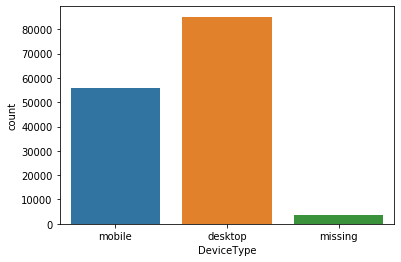

In [35]:
sns.countplot(train_identity_data['DeviceType'])

In [36]:
raw_train_data = pd.merge(train_transaction_data, train_identity_data, on='TransactionID', how='left')
del train_transaction_data,train_identity_data

In [37]:
raw_train_data_columns = raw_train_data.columns
numericCols = raw_train_data._get_numeric_data().columns
categoricalCols = list(set(raw_train_data_columns) - set(numericCols))
print('The categorical columns in training data are: ',categoricalCols)
raw_train_data[categoricalCols] = raw_train_data[categoricalCols].replace({ np.nan:'missing'})
raw_train_data[numericCols] = raw_train_data[numericCols].replace({ np.nan:-1})

The categorical columns in training data are:  ['M7', 'id_38', 'R_emaildomain', 'id_23', 'id_27', 'id_28', 'M4', 'M9', 'M8', 'card4', 'M2', 'id_30', 'id_34', 'id_37', 'M5', 'M3', 'id_16', 'DeviceInfo', 'id_15', 'M6', 'id_35', 'device_name', 'ProductCD', 'id_36', 'id_12', 'id_33', 'M1', 'id_31', 'id_29', 'DeviceType', 'P_emaildomain', 'card6']


In [38]:
reduce_memory_usage(raw_train_data, deep=True, verbose=True)
print(raw_train_data.head(10))

Column 'TransactionID' converted from int64 to int32
Column 'isFraud' converted from int64 to int8
Column 'TransactionDT' converted from int64 to int32
Column 'TransactionAmt' converted from float64 to float32
Column 'card1' converted from int64 to int16
Column 'card2' converted from float64 to float32
Column 'card3' converted from float64 to float32
Column 'card5' converted from float64 to float32
Column 'addr1' converted from float64 to float32
Column 'addr2' converted from float64 to float32
Column 'dist1' converted from float64 to float32
Column 'dist2' converted from float64 to float32
Column 'C1' converted from float64 to float32
Column 'C2' converted from float64 to float32
Column 'C3' converted from float64 to float32
Column 'C4' converted from float64 to float32
Column 'C5' converted from float64 to float32
Column 'C6' converted from float64 to float32
Column 'C7' converted from float64 to float32
Column 'C8' converted from float64 to float32
Column 'C9' converted from float64

Column 'V134' converted from float64 to float32
Column 'V135' converted from float64 to float32
Column 'V136' converted from float64 to float32
Column 'V137' converted from float64 to float32
Column 'V138' converted from float64 to float32
Column 'V139' converted from float64 to float32
Column 'V140' converted from float64 to float32
Column 'V141' converted from float64 to float32
Column 'V142' converted from float64 to float32
Column 'V143' converted from float64 to float32
Column 'V144' converted from float64 to float32
Column 'V145' converted from float64 to float32
Column 'V146' converted from float64 to float32
Column 'V147' converted from float64 to float32
Column 'V148' converted from float64 to float32
Column 'V149' converted from float64 to float32
Column 'V150' converted from float64 to float32
Column 'V151' converted from float64 to float32
Column 'V152' converted from float64 to float32
Column 'V153' converted from float64 to float32
Column 'V154' converted from float64 to 

Column 'V305' converted from float64 to float32
Column 'V306' converted from float64 to float32
Column 'V307' converted from float64 to float32
Column 'V308' converted from float64 to float32
Column 'V309' converted from float64 to float32
Column 'V310' converted from float64 to float32
Column 'V311' converted from float64 to float32
Column 'V312' converted from float64 to float32
Column 'V313' converted from float64 to float32
Column 'V314' converted from float64 to float32
Column 'V315' converted from float64 to float32
Column 'V316' converted from float64 to float32
Column 'V317' converted from float64 to float32
Column 'V318' converted from float64 to float32
Column 'V319' converted from float64 to float32
Column 'V320' converted from float64 to float32
Column 'V321' converted from float64 to float32
Column 'V322' converted from float64 to float32
Column 'V323' converted from float64 to float32
Column 'V324' converted from float64 to float32
Column 'V325' converted from float64 to 

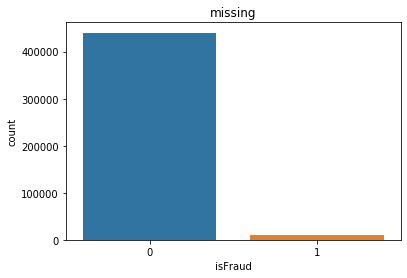

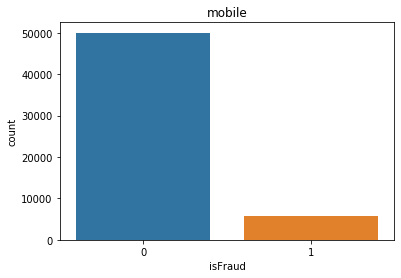

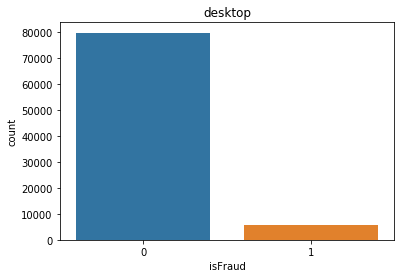

In [39]:
deviceTypes = raw_train_data['DeviceType'].unique()
for i,i_device in enumerate(deviceTypes):
    deviceData = eval('raw_train_data.loc[raw_train_data["DeviceType"]=="'+i_device+'"]')
    plt.figure(i)
    sns.countplot(deviceData['isFraud']).set_title(i_device)

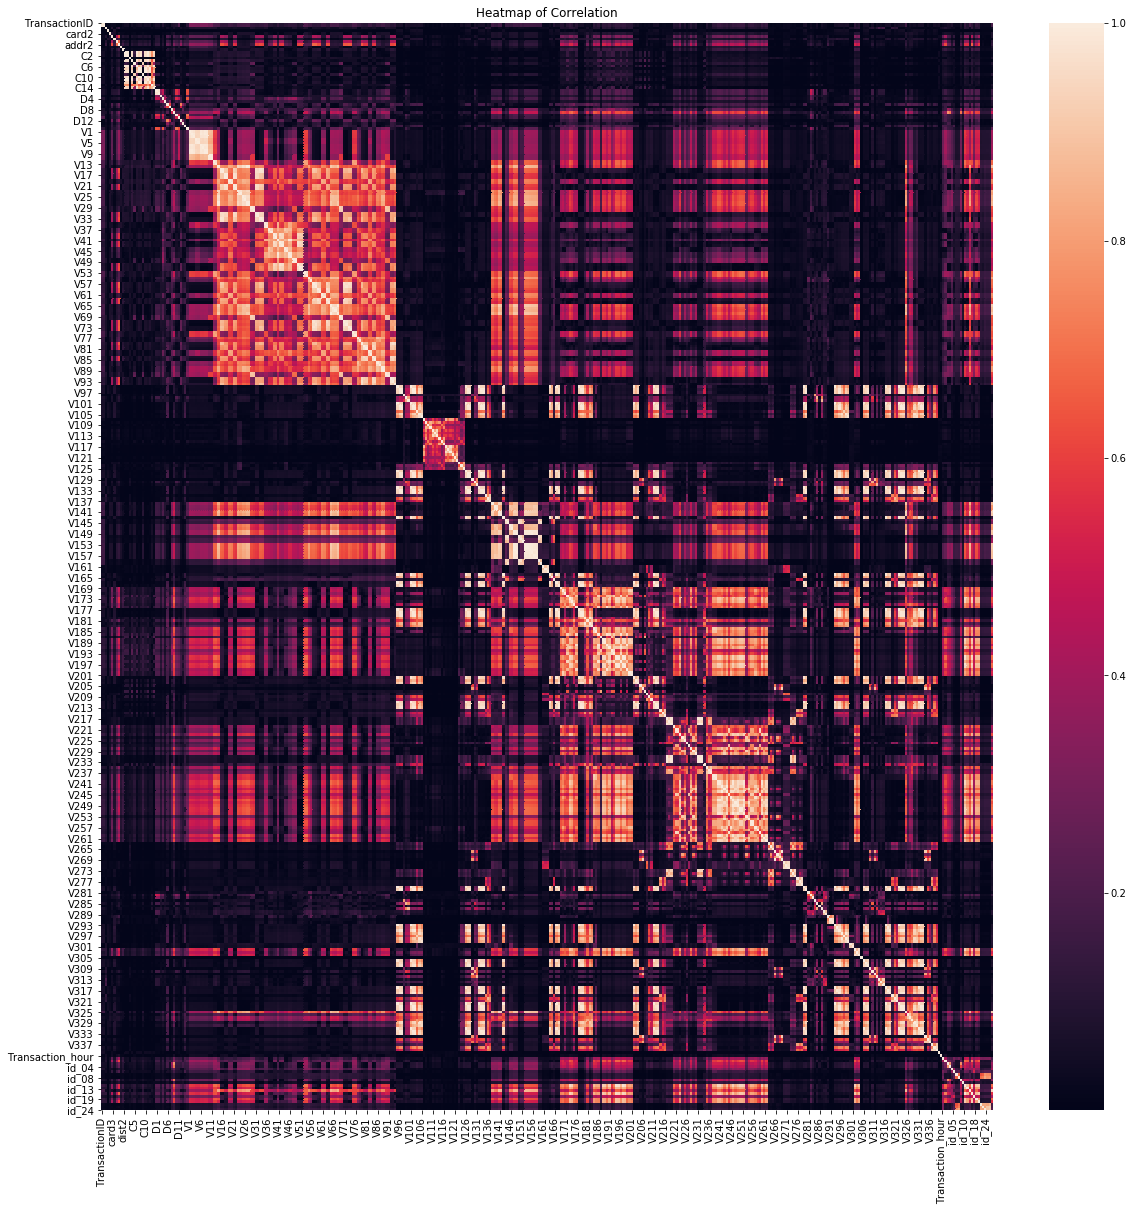

In [40]:
#
# Notes:
# looks like merging the two data tables has created a lot of missing values. 
# let us first try to identify good features from these.
#
variables = list(numericCols)
variables.remove('isFraud')
correlationMatrix = raw_train_data.loc[:, variables].corr().abs()
plt.figure(figsize=(20,20))
heat = sns.heatmap(data=correlationMatrix)
plt.title('Heatmap of Correlation')
na_vals = np.sum(raw_train_data.loc[:,variables]==-1)/raw_train_data.shape[0]
goodNumericVars = []
for i_var in variables:    
    if na_vals[i_var] < 1:        
        goodNumericVars.append(i_var)
goodNumericVars.remove('TransactionDT')
goodNumericVars.remove('TransactionID')
corrThresh = 0.9
# Select upper triangle of correlation matrix
upper = correlationMatrix.where(np.triu(np.ones(correlationMatrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > corrThresh)]
to_drop.remove('TransactionDT')

In [41]:
for i_var in to_drop:
    if i_var in goodNumericVars:
        goodNumericVars.remove(i_var)

In [42]:
#
# Now that we have identified good numeric variables, 
# let us use just the missing data as benchmark for the categorical variables
#
del to_drop,corrThresh,upper,correlationMatrix,na_vals

In [43]:
variables = list(categoricalCols)
na_vals = np.sum(raw_train_data.loc[:,variables]=='missing')/raw_train_data.shape[0]
goodCategoricalVars = []
for i_var in variables:    
    if na_vals[i_var] < 1:        
        goodCategoricalVars.append(i_var)

In [44]:
featuresToUse = goodNumericVars+goodCategoricalVars
train_data = raw_train_data.loc[:,featuresToUse]
target_data = raw_train_data['isFraud']

In [45]:
featuresToUse

['TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C3',
 'C5',
 'C13',
 'D1',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V10',
 'V12',
 'V14',
 'V15',
 'V19',
 'V29',
 'V35',
 'V37',
 'V39',
 'V41',
 'V48',
 'V53',
 'V55',
 'V56',
 'V61',
 'V75',
 'V77',
 'V78',
 'V79',
 'V80',
 'V82',
 'V86',
 'V88',
 'V95',
 'V98',
 'V99',
 'V100',
 'V104',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V129',
 'V130',
 'V131',
 'V135',
 'V136',
 'V138',
 'V139',
 'V144',
 'V146',
 'V161',
 'V162',
 'V165',
 'V166',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V175',
 'V176',
 'V180',
 'V181',
 'V184',
 'V187',
 'V188',
 'V192',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V214',
 'V215',
 'V217',
 'V220',
 'V221',
 'V223',
 'V224',
 'V226',
 'V227',
 'V228',
 'V2

In [46]:
train_data['TransactionAmt_decimal'] = ((train_data['TransactionAmt'] - train_data['TransactionAmt'].astype(int)) * 1000).astype(int)

In [47]:
#https://www.kaggle.com/artgor/eda-and-models#Feature-engineering
train_data['TransactionAmt_to_mean_card1'] = train_data['TransactionAmt'] / train_data.groupby(['card1'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_card4'] = train_data['TransactionAmt'] / train_data.groupby(['card4'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_card5'] = train_data['TransactionAmt'] / train_data.groupby(['card5'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_ProductCD'] = train_data['TransactionAmt'] / train_data.groupby(['ProductCD'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_addr1'] = train_data['TransactionAmt'] / train_data.groupby(['addr1'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_id31'] = train_data['TransactionAmt'] / train_data.groupby(['id_31'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_devicename'] = train_data['TransactionAmt'] / train_data.groupby(['device_name'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_dow'] = train_data['TransactionAmt'] / train_data.groupby(['Transaction_dow'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_hour'] = train_data['TransactionAmt'] / train_data.groupby(['Transaction_hour'])['TransactionAmt'].transform('mean')
train_data['card1_card2'] = train_data['card1'].astype(str) + '_' + train_data['card2'].astype(str)
train_data['addr1_dist1'] = train_data['addr1'].astype(str) + '_' + train_data['dist1'].astype(str)
train_data['card1_addr1'] = train_data['card1'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card1_addr2'] = train_data['card1'].astype(str) + '_' + train_data['addr2'].astype(str)
train_data['card2_addr1'] = train_data['card2'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card2_addr2'] = train_data['card2'].astype(str) + '_' + train_data['addr2'].astype(str)
train_data['card4_addr1'] = train_data['card4'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['card4_addr2'] = train_data['card4'].astype(str) + '_' + train_data['addr2'].astype(str)
train_data['DeviceInfo_P_emaildomain'] = train_data['DeviceInfo'].astype(str) + '_' + train_data['P_emaildomain'].astype(str)
train_data['P_emaildomain_addr1'] = train_data['P_emaildomain'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['id01_addr1'] = train_data['id_01'].astype(str) + '_' + train_data['addr1'].astype(str)
train_data['TransactionAmt_to_std_card1'] = train_data['TransactionAmt'] / train_data.groupby(['card1'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_card4'] = train_data['TransactionAmt'] / train_data.groupby(['card4'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_card5'] = train_data['TransactionAmt'] / train_data.groupby(['card5'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_ProductCD'] = train_data['TransactionAmt'] / train_data.groupby(['ProductCD'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_addr1'] = train_data['TransactionAmt'] / train_data.groupby(['addr1'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_id31'] = train_data['TransactionAmt'] / train_data.groupby(['id_31'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_devicename'] = train_data['TransactionAmt'] / train_data.groupby(['device_name'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_dow'] = train_data['TransactionAmt'] / train_data.groupby(['Transaction_dow'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_hour'] = train_data['TransactionAmt'] / train_data.groupby(['Transaction_hour'])['TransactionAmt'].transform('std')


In [48]:
train_data['TransactionAmt_to_mean_C1'] = train_data['TransactionAmt'] / train_data.groupby(['C1'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C3'] = train_data['TransactionAmt'] / train_data.groupby(['C3'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C5'] = train_data['TransactionAmt'] / train_data.groupby(['C5'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_C13'] = train_data['TransactionAmt'] / train_data.groupby(['C13'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_mean_D15'] = train_data['TransactionAmt'] / train_data.groupby(['D15'])['TransactionAmt'].transform('mean')
train_data['TransactionAmt_to_std_C1'] = train_data['TransactionAmt'] / train_data.groupby(['C1'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_C3'] = train_data['TransactionAmt'] / train_data.groupby(['C3'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_C5'] = train_data['TransactionAmt'] / train_data.groupby(['C5'])['TransactionAmt'].transform('std')
train_data['TransactionAmt_to_std_D15'] = train_data['TransactionAmt'] / train_data.groupby(['D15'])['TransactionAmt'].transform('std')

In [49]:
# In WYSIWYG
train_data['card1_counts'] = train_data['card1'].map(train_data['card1'].value_counts(dropna=False))
train_data['card3_counts'] = train_data['card3'].map(train_data['card3'].value_counts(dropna=False))
train_data['card5_counts'] = train_data['card5'].map(train_data['card5'].value_counts(dropna=False))
train_data['card2_counts'] = train_data['card2'].map(train_data['card2'].value_counts(dropna=False))

In [50]:
scale_pos_weight = np.sqrt(len(target_data.loc[target_data==0])/len(target_data.loc[target_data==1]))
del raw_train_data

In [51]:
test_identity_data = pd.read_csv('../input-hw3/test_identity.csv')
test_transaction_data = pd.read_csv('../input-hw3/test_transaction.csv')

In [52]:
na_columns = test_transaction_data.isna().sum()
print(na_columns[na_columns==0])
print(na_columns[na_columns>0]/test_transaction_data.shape[0])

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
V95               0
V96               0
V97               0
V98               0
V99               0
V100              0
V101              0
V102              0
V103              0
V104              0
V105              0
V106              0
V107              0
V108              0
V109              0
V110              0
V111              0
V112              0
V113              0
V114              0
V115              0
V116              0
V117              0
V118              0
V119              0
V120              0
V121              0
V122              0
V123              0
V124              0
V125              0
V126              0
V127              0
V128              0
V129              0
V130              0
V131              0
V132              0
V133              0
V134              0
V135              0
V136              0
V137              0
dtype: int64
card2            0.017079
c

In [53]:
# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
test_transaction_data['Transaction_dow'] = np.floor((test_transaction_data['TransactionDT'] / (3600 * 24) - 1) % 7)
test_transaction_data['Transaction_hour'] = np.floor(test_transaction_data['TransactionDT'] / 3600) % 24
transaction_data_columns = test_transaction_data.columns
numericCols = test_transaction_data._get_numeric_data().columns
categoricalCols = list(set(transaction_data_columns) - set(numericCols))
test_transaction_data[categoricalCols] = test_transaction_data[categoricalCols].replace({ np.nan:'missing'})
test_transaction_data[numericCols] = test_transaction_data[numericCols].replace({ np.nan:-1})

In [54]:
identity_data_columns = test_identity_data.columns
numericCols = test_identity_data._get_numeric_data().columns
categoricalCols = list(set(identity_data_columns) - set(numericCols))
test_identity_data[categoricalCols] = test_identity_data[categoricalCols].replace({ np.nan:'missing'})
test_identity_data[numericCols] = test_identity_data[numericCols].replace({ np.nan:-1})
test_identity_data['id_31'] = test_identity_data['id_31'].str.replace('\d+', '')

test_identity_data.loc[test_identity_data['id_30'].str.contains('Mac', na=False), 'id_30'] = 'mac'
test_identity_data.loc[test_identity_data['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
test_identity_data.loc[test_identity_data['id_30'].str.contains('Android', na=False), 'id_30'] = 'android'
test_identity_data.loc[test_identity_data['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
test_identity_data.loc[test_identity_data['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'
test_identity_data['device_name'] = test_identity_data['DeviceInfo'].str.split('/', expand=True)[0]

test_identity_data.loc[test_identity_data['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
test_identity_data.loc[test_identity_data['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
test_identity_data.loc[test_identity_data['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
test_identity_data.loc[test_identity_data['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
test_identity_data.loc[test_identity_data['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
test_identity_data.loc[test_identity_data['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
test_identity_data.loc[test_identity_data['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
test_identity_data.loc[test_identity_data['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
test_identity_data.loc[test_identity_data['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
test_identity_data.loc[test_identity_data['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
test_identity_data.loc[test_identity_data['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
test_identity_data.loc[test_identity_data['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
test_identity_data.loc[test_identity_data['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
test_identity_data.loc[test_identity_data['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

test_identity_data.loc[test_identity_data.device_name.isin(test_identity_data.device_name.value_counts()[test_identity_data.device_name.value_counts() < 200].index), 'device_name'] = "Others"


In [55]:
raw_test_data = pd.merge(test_transaction_data, test_identity_data, on='TransactionID', how='left')
transactionID = raw_test_data.loc[:,'TransactionID']
del test_identity_data,test_transaction_data

In [56]:
raw_test_data_columns = raw_test_data.columns
numericCols = raw_test_data._get_numeric_data().columns
categoricalCols = list(set(raw_test_data_columns) - set(numericCols))
print('The categorical columns in training data are: ',categoricalCols)
raw_test_data[categoricalCols] = raw_test_data[categoricalCols].replace({ np.nan:'missing'})
raw_test_data[numericCols] = raw_test_data[numericCols].replace({ np.nan:-1})
reduce_memory_usage(raw_test_data, deep=True, verbose=True)

The categorical columns in training data are:  ['M7', 'id_38', 'R_emaildomain', 'id_23', 'id_27', 'id_28', 'M4', 'M9', 'M8', 'card4', 'M2', 'id_30', 'id_34', 'id_37', 'M5', 'M3', 'id_16', 'DeviceInfo', 'id_15', 'M6', 'id_35', 'device_name', 'ProductCD', 'id_36', 'id_12', 'id_33', 'M1', 'id_31', 'id_29', 'DeviceType', 'P_emaildomain', 'card6']
Column 'TransactionID' converted from int64 to int32
Column 'TransactionDT' converted from int64 to int32
Column 'TransactionAmt' converted from float64 to float32
Column 'card1' converted from int64 to int16
Column 'card2' converted from float64 to float32
Column 'card3' converted from float64 to float32
Column 'card5' converted from float64 to float32
Column 'addr1' converted from float64 to float32
Column 'addr2' converted from float64 to float32
Column 'dist1' converted from float64 to float32
Column 'dist2' converted from float64 to float32
Column 'C1' converted from float64 to float32
Column 'C2' converted from float64 to float32
Column 'C3'

Column 'V128' converted from float64 to float32
Column 'V129' converted from float64 to float32
Column 'V130' converted from float64 to float32
Column 'V131' converted from float64 to float32
Column 'V132' converted from float64 to float32
Column 'V133' converted from float64 to float32
Column 'V134' converted from float64 to float32
Column 'V135' converted from float64 to float32
Column 'V136' converted from float64 to float32
Column 'V137' converted from float64 to float32
Column 'V138' converted from float64 to float32
Column 'V139' converted from float64 to float32
Column 'V140' converted from float64 to float32
Column 'V141' converted from float64 to float32
Column 'V142' converted from float64 to float32
Column 'V143' converted from float64 to float32
Column 'V144' converted from float64 to float32
Column 'V145' converted from float64 to float32
Column 'V146' converted from float64 to float32
Column 'V147' converted from float64 to float32
Column 'V148' converted from float64 to 

Column 'V299' converted from float64 to float32
Column 'V300' converted from float64 to float32
Column 'V301' converted from float64 to float32
Column 'V302' converted from float64 to float32
Column 'V303' converted from float64 to float32
Column 'V304' converted from float64 to float32
Column 'V305' converted from float64 to float32
Column 'V306' converted from float64 to float32
Column 'V307' converted from float64 to float32
Column 'V308' converted from float64 to float32
Column 'V309' converted from float64 to float32
Column 'V310' converted from float64 to float32
Column 'V311' converted from float64 to float32
Column 'V312' converted from float64 to float32
Column 'V313' converted from float64 to float32
Column 'V314' converted from float64 to float32
Column 'V315' converted from float64 to float32
Column 'V316' converted from float64 to float32
Column 'V317' converted from float64 to float32
Column 'V318' converted from float64 to float32
Column 'V319' converted from float64 to 

In [57]:
test_data = raw_test_data.loc[:,featuresToUse]
# New feature - decimal part of the transaction amount.
test_data['TransactionAmt_decimal'] = ((test_data['TransactionAmt'] - test_data['TransactionAmt'].astype(int)) * 1000).astype(int)

In [58]:
#https://www.kaggle.com/artgor/eda-and-models#Feature-engineering
test_data['TransactionAmt_to_mean_card1'] = test_data['TransactionAmt'] / test_data.groupby(['card1'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_card4'] = test_data['TransactionAmt'] / test_data.groupby(['card4'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_card5'] = test_data['TransactionAmt'] / test_data.groupby(['card5'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_ProductCD'] = test_data['TransactionAmt'] / test_data.groupby(['ProductCD'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_addr1'] = test_data['TransactionAmt'] / test_data.groupby(['addr1'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_id31'] = test_data['TransactionAmt'] / test_data.groupby(['id_31'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_devicename'] = test_data['TransactionAmt'] / test_data.groupby(['device_name'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_dow'] = test_data['TransactionAmt'] / test_data.groupby(['Transaction_dow'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_hour'] = test_data['TransactionAmt'] / test_data.groupby(['Transaction_hour'])['TransactionAmt'].transform('mean')
test_data['card1_card2'] = test_data['card1'].astype(str) + '_' + test_data['card2'].astype(str)
test_data['addr1_dist1'] = test_data['addr1'].astype(str) + '_' + test_data['dist1'].astype(str)
test_data['card1_addr1'] = test_data['card1'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card1_addr2'] = test_data['card1'].astype(str) + '_' + test_data['addr2'].astype(str)
test_data['card2_addr1'] = test_data['card2'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card2_addr2'] = test_data['card2'].astype(str) + '_' + test_data['addr2'].astype(str)
test_data['card4_addr1'] = test_data['card4'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['card4_addr2'] = test_data['card4'].astype(str) + '_' + test_data['addr2'].astype(str)
test_data['DeviceInfo_P_emaildomain'] = test_data['DeviceInfo'].astype(str) + '_' + test_data['P_emaildomain'].astype(str)
test_data['P_emaildomain_addr1'] = test_data['P_emaildomain'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['id01_addr1'] = test_data['id_01'].astype(str) + '_' + test_data['addr1'].astype(str)
test_data['TransactionAmt_to_std_card1'] = test_data['TransactionAmt'] / test_data.groupby(['card1'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_card4'] = test_data['TransactionAmt'] / test_data.groupby(['card4'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_card5'] = test_data['TransactionAmt'] / test_data.groupby(['card5'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_ProductCD'] = test_data['TransactionAmt'] / test_data.groupby(['ProductCD'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_addr1'] = test_data['TransactionAmt'] / test_data.groupby(['addr1'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_id31'] = test_data['TransactionAmt'] / test_data.groupby(['id_31'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_devicename'] = test_data['TransactionAmt'] / test_data.groupby(['device_name'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_dow'] = test_data['TransactionAmt'] / test_data.groupby(['Transaction_dow'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_hour'] = test_data['TransactionAmt'] / test_data.groupby(['Transaction_hour'])['TransactionAmt'].transform('std')


In [59]:
test_data['TransactionAmt_to_mean_C1'] = test_data['TransactionAmt'] / test_data.groupby(['C1'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C3'] = test_data['TransactionAmt'] / test_data.groupby(['C3'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C5'] = test_data['TransactionAmt'] / test_data.groupby(['C5'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_C13'] = test_data['TransactionAmt'] / test_data.groupby(['C13'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_mean_D15'] = test_data['TransactionAmt'] / test_data.groupby(['D15'])['TransactionAmt'].transform('mean')
test_data['TransactionAmt_to_std_C1'] = test_data['TransactionAmt'] / test_data.groupby(['C1'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_C3'] = test_data['TransactionAmt'] / test_data.groupby(['C3'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_C5'] = test_data['TransactionAmt'] / test_data.groupby(['C5'])['TransactionAmt'].transform('std')
test_data['TransactionAmt_to_std_D15'] = test_data['TransactionAmt'] / test_data.groupby(['D15'])['TransactionAmt'].transform('std')

In [60]:
test_data['card1_counts'] = test_data['card1'].map(test_data['card1'].value_counts(dropna=False))
test_data['card3_counts'] = test_data['card3'].map(test_data['card3'].value_counts(dropna=False))
test_data['card5_counts'] = test_data['card5'].map(test_data['card5'].value_counts(dropna=False))
test_data['card2_counts'] = test_data['card2'].map(test_data['card2'].value_counts(dropna=False))

In [61]:
goodCategoricalVars.append('card1_addr1')
goodCategoricalVars.append('card1_addr2')
goodCategoricalVars.append('card2_addr1')
goodCategoricalVars.append('card2_addr2')
goodCategoricalVars.append('card4_addr1')
goodCategoricalVars.append('card4_addr2')
goodCategoricalVars.append('DeviceInfo_P_emaildomain')
goodCategoricalVars.append('P_emaildomain_addr1')
goodCategoricalVars.append('id01_addr1')
goodCategoricalVars.append('card1_card2')
goodCategoricalVars.append('device_name')
goodCategoricalVars.append('addr1_dist1')
from sklearn.preprocessing import LabelEncoder
for i_cat in goodCategoricalVars:
    le = LabelEncoder()
    curData = pd.concat([train_data.loc[:,i_cat],test_data.loc[:,i_cat]],axis = 0)
    le.fit(curData)
    train_data.loc[:,i_cat] = le.transform(train_data.loc[:,i_cat])   
    test_data.loc[:,i_cat] = le.transform(test_data.loc[:,i_cat])

In [62]:
print('The shape of training data is:',np.shape(train_data))
del raw_test_data

The shape of training data is: (590540, 245)


In [63]:
#######################

#Bayes Classification


from sklearn.model_selection import StratifiedKFold,GroupKFold
from sklearn.metrics import roc_curve, auc
from lightgbm import LGBMClassifier
import lightgbm as lgb

#group_kfold = GroupKFold(n_splits=5)
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [64]:
def compute_roc_auc(clf,index):
    y_predict = clf.predict_proba(train_data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(target_data.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [65]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (1, 4),   
    'reg_alpha': (0.2,2), 
    'reg_lambda': (0.2,2),
    'max_depth':(-1,50),
    'n_estimators':(750,7500)
}

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.25, random_state=42)
train_index = X_train.index
test_index = X_test.index

print(X_train.isnull().sum())
print(y_train.isnull().sum())

################################
# Logistic Regression
# df

clf = LogisticRegression(n_jobs=-1)
# X_train.fillna(X_train.mean())
# y_train.fillna(y_train.mean())
# X_train.fillna('missing')
# y_train.fillna('missing')
#train_transaction_data[categoricalCols] = train_transaction_data[categoricalCols].replace({ np.nan:'missing'})
#train_transaction_data[numericCols] = train_transaction_data[numericCols].replace({ np.nan:-1})
#X_train.
#y_train.

#transaction_data_columns = train_transaction_data.columns

#numericCols = train_transaction_data._get_numeric_data().columns
#categoricalCols = list(set(transaction_data_columns) - set(numericCols))

#print('The categorical columns in transaction data are: ',categoricalCols)

X_train_data_columns = X_train.columns
X_train_numericCols = X_train._get_numeric_data().columns
X_train_categoricalCols = list(set(X_train_data_columns) - set(X_train_numericCols))
print('The X_train categorical columns in transaction data are: ',X_train_categoricalCols)
X_train[X_train_categoricalCols] = X_train[X_train_categoricalCols].replace({ np.nan:'missing'})
X_train[X_train_numericCols] = X_train[X_train_numericCols].replace({ np.nan:-1})

#y_train_data_columns = y_train.columns
#y_train_numericCols = y_train._get_numeric_data().columns
#y_train_categoricalCols = list(set(y_train_data_columns) - set(y_train_numericCols))
#print('The X_train categorical columns in transaction data are: ',X_train_categoricalCols)
#y_train[X_train_categoricalCols] = y_train[y_train_categoricalCols].replace({ np.nan:'missing'})
#y_train[X_train_numericCols] = y_train[y_train_numericCols].replace({ np.nan:-1})

# if a result (FRAUD / NOT FRUAD) is missed in data, assume NOT FRAUD
##y_train = y_train.replace({ np.nan:0})

##print("X_train.isnull().sum() ", X_train.isnull().sum())
##print("y_train.isnull().sum() ", y_train.isnull().sum())
##X_train = X_train.replace(np.NaN, 0)
##y_train = y_train.replace(np.NaN, 0)
print("X_train.isnull().sum() ", X_train.isnull().sum())
print("y_train.isnull().sum() ", y_train.isnull().sum())
#if not np.isfinite(X_train)
##
#X_train_nan = X_train.replace([np.inf, -np.inf], np.nan).dropna(subset=X_train.columns, how="all")
#X_train_nan = X_train.replace([np.inf, -np.inf], np.nan)
#X_train_nan = X_train.replace(to_replace = [np.inf, -np.inf], value = np.nan)
#X_train_nan = X_train.replace(to_replace = {np.inf:np.nan, -np.inf:np.nan}, inplace=False)
#X_train_nan = X_train.replace(to_replace = {np.inf:np.nan, -np.inf:np.nan})
#X_train_nan = X_train.replace(to_replace = np.inf, value = np.nan, inplace=False)
X_train_z = X_train.replace(to_replace = np.inf, value = "-1")
X_train_nan = X_train_z.replace(to_replace = -np.inf, value = "-1")


print("All finite in y_train? ", np.all(np.isfinite(y_train)))
print("All finite in X_train? ", np.all(np.isfinite(X_train)))
print("All finite in X_train_nan? ", np.all(np.isfinite(X_train_nan)))
###print("X_train_nan.isnull().sum() ", X_train_nan.isnull().sum())

##X_train.fillna(X_train.mean(), inplace=True)
##X_train_nan.fillna(X_train_nan.mean(), inplace=True)
##

#clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

with open('logisticregression.pickle','wb') as f:
    pickle.dump(clf, f)

pickle_in = open('logisticregression.pickle','rb')
clf = pickle.load(pickle_in)

confidence = clf.score(X_test, y_test)

forecast_set = clf.predict(X_lately)
forecast_set.tail()                        
                         
                         
                         
                         
df['Logistic Regression Forecast'] = np.nan
stop = now



last_date = df.iloc[-1].name
last_unix = last_date
next_unix = last_unix + timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += timedelta(days=1)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]    

df_LRforecast = df.copy()

# Logistic Regression
################################



def LGB_bayesian(num_leaves,bagging_fraction,feature_fraction,min_child_weight,
                 min_data_in_leaf,max_depth,n_estimators,reg_alpha,reg_lambda,learning_rate):
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    min_child_weight = int(min_child_weight)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    assert type(n_estimators) == int
    assert type(min_child_weight) == int
    param = {'num_leaves': num_leaves,'min_data_in_leaf': min_data_in_leaf,'min_child_weight': min_child_weight,'bagging_fraction' : bagging_fraction,
             'feature_fraction' : feature_fraction,'max_depth': max_depth,'reg_alpha': reg_alpha,'reg_lambda': reg_lambda,
              'objective': 'binary','boosting_type': 'gbdt','colsample_bytree':.8,'subsample':.9,'min_split_gain':.01,'max_bin':127,
             'bagging_freq':5,'learning_rate':learning_rate,'metric':'auc','n_estimators':n_estimators,'min_data_in_leaf':min_data_in_leaf,
            'early_stopping_rounds':100} 
    lgb_bayes = LGBMClassifier(boosting = param['boosting_type'],n_estimators =  param['n_estimators'],
                     learning_rate =  param['learning_rate'],num_leaves =  param['num_leaves'],
                     colsample_bytree = param['colsample_bytree'],subsample =  param['subsample'],
                     max_depth =  param['max_depth'],reg_alpha =  param['reg_alpha'],
                     reg_lambda =  param['reg_lambda'],min_split_gain =  param['min_split_gain'],
                     min_child_weight =  param['min_child_weight'],max_bin =  param['max_bin'],
                     bagging_freq =  param['bagging_freq'],feature_fraction =  param['feature_fraction'],
                     bagging_fraction =  param['bagging_fraction'],min_data_in_leaf = param['min_data_in_leaf'],
                              early_stopping_rounds = param['early_stopping_rounds'])
    lgb_bayes.fit(train_data.iloc[train_index,:], target_data.iloc[train_index],
                 eval_set = [(train_data.iloc[train_index,:], target_data.iloc[train_index]), 
                             (train_data.iloc[test_index,:], target_data.iloc[test_index])],eval_metric='auc',verbose = 200)
    fpr, tpr, auc_score = compute_roc_auc(lgb_bayes,test_index)  
    return auc_score
lightGBM_bo = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)
print(lightGBM_bo.space.keys)
init_points = 10
n_iter = 25
print('-' * 130)

lightGBM_bo.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
print(lightGBM_bo.max['target'])
lightGBM_bo.max['params']
params = {
        'n_estimators': int(lightGBM_bo.max['params']['n_estimators']), 
        'num_leaves': int(lightGBM_bo.max['params']['num_leaves']), 
        'min_child_weight': lightGBM_bo.max['params']['min_child_weight'],
        'min_data_in_leaf': int(lightGBM_bo.max['params']['min_data_in_leaf']),
        'bagging_fraction': lightGBM_bo.max['params']['bagging_fraction'], 
        'feature_fraction': lightGBM_bo.max['params']['feature_fraction'],
        'reg_lambda': lightGBM_bo.max['params']['reg_lambda'],
        'reg_alpha': lightGBM_bo.max['params']['reg_alpha'],
        'max_depth': int(lightGBM_bo.max['params']['max_depth']), 
        'metric':'auc',
        'boosting_type': 'gbdt',
        'colsample_bytree':.8,'subsample':.9,
        'min_split_gain':.01,
        'max_bin':127,
        'bagging_freq':5,
        'learning_rate':lightGBM_bo.max['params']['learning_rate'],
        #'learning_rate':0.01,
        'early_stopping_rounds':100
    }

TransactionAmt                          0
card1                                   0
card2                                   0
card3                                   0
card5                                   0
addr1                                   0
addr2                                   0
dist1                                   0
dist2                                   0
C1                                      0
C3                                      0
C5                                      0
C13                                     0
D1                                      0
D3                                      0
D4                                      0
D5                                      0
D6                                      0
D7                                      0
D8                                      0
D9                                      0
D10                                     0
D11                                     0
D12                               

c:\users\georg\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


X_train.isnull().sum()  TransactionAmt                       0
card1                                0
card2                                0
card3                                0
card5                                0
addr1                                0
addr2                                0
dist1                                0
dist2                                0
C1                                   0
C3                                   0
C5                                   0
C13                                  0
D1                                   0
D3                                   0
D4                                   0
D5                                   0
D6                                   0
D7                                   0
D8                                   0
D9                                   0
D10                                  0
D11                                  0
D12                                  0
D13                                  0
D

All finite in y_train?  True
All finite in X_train?  False


KeyboardInterrupt: 

In [ ]:
# In WYSIWYG
params = {'bagging_fraction': 0.7982116702024386, 
          'feature_fraction': 0.1785051643813966, 
          'max_depth': int(49.17611603427576), 
          'min_child_weight': 3.2852905549011155, 
          'min_data_in_leaf': int(31.03480802715621), 
          'n_estimators': 2000,#int(1491.3676131788188), 
          'num_leaves': int(52.851307790411965), 
          'reg_alpha': 0.45963319421692145, 
          'reg_lambda': 0.6591286807489907, 
          'metric':'auc',
          'boosting_type': 'dart', 
          'colsample_bytree':.8, 
          'subsample':.9, 
          'min_split_gain':.01, 
          'max_bin':127, 
          'bagging_freq':5, 
          'learning_rate':0.01 , 
          'early_stopping_rounds':100 }

In [ ]:
fprs_lgb, tprs_lgb, scores_lgb = [], [], []
feature_importances = pd.DataFrame()
feature_importances['feature'] = train_data.columns     
predictions = np.zeros(len(test_data))
for (train, test), i in zip(cv.split(train_data, target_data), range(5)):
    lgb_best = LGBMClassifier(boosting = params['boosting_type'],n_estimators =  params['n_estimators'],
                     learning_rate =  params['learning_rate'],num_leaves =  params['num_leaves'],
                     colsample_bytree = params['colsample_bytree'],subsample =  params['subsample'],
                     max_depth =  params['max_depth'],reg_alpha =  params['reg_alpha'],
                     reg_lambda =  params['reg_lambda'],min_split_gain =  params['min_split_gain'],
                     min_child_weight =  params['min_child_weight'],max_bin =  params['max_bin'],
                     bagging_freq =  params['bagging_freq'],feature_fraction =  params['feature_fraction'],
                     bagging_fraction =  params['bagging_fraction'],min_data_in_leaf = params['min_data_in_leaf'],
                             early_stopping_rounds = params['early_stopping_rounds'])
    lgb_best.fit(train_data.iloc[train,:], target_data.iloc[train],
                 eval_set = [(train_data.iloc[train,:], target_data.iloc[train]), 
                             (train_data.iloc[test,:], target_data.iloc[test])],eval_metric='auc',verbose = 200)    
    feature_importances['fold_{}'.format(i + 1)] = lgb_best.feature_importances_
    _, _, auc_score_train = compute_roc_auc(lgb_best,train)
    fpr, tpr, auc_score = compute_roc_auc(lgb_best,test)
    scores_lgb.append((auc_score_train, auc_score))
    fprs_lgb.append(fpr)
    tprs_lgb.append(tpr) 
    predictions += lgb_best.predict_proba(test_data, num_iteration=lgb_best.best_iteration_)[:,1]/cv.n_splits

In [ ]:
plt.figure()
lw = 2
colors = ['black','red','blue','darkorange','green']
for i in range(0,5):
    plt.plot(fprs_lgb[i], tprs_lgb[i], color=colors[i],
             lw=lw, label='ROC curve (area = %0.5f)' % scores_lgb[i][1])
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
scores_lgb



In [ ]:
print('Mean AUC:', np.mean(scores_lgb,axis = 0))

In [ ]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(cv.n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(cv.n_splits));

#Bayes Classification
#######################

In [ ]:
del train_data,target_data

In [ ]:
data = {'TransactionID':transactionID,'isFraud':predictions}
submissionDF = pd.DataFrame(data)
submissionDF.to_csv('sample_submission_LogReg.csv',index=False)